`Author`: Zhixin Li

# Instruction of using the notebook

<font color="red">Basically, you can run the whole notebook directly.</font> Because all of the data that consumes time to run is downloaded already and stored as csv or pkl files. All the codes related to the time consuming downloads are blocked. If you want to adjust the time period and update the data, please do <font color="red">unblock all the blocked codes</font> and run the whole notebook.
<br><font color="red">**Notice**</font>: You do need to install the packages listed below cause no requirement.txt is provided.

There are totally three parts of the code.
- (1) Getting the data of the assets, compute the empirical returns, and launch correlation analysis. Most importantly, the covariance denoising.
- (2) Using the Black-Litterman model to update the equilibrium return to posterior return. Then use the posterior return to find optimal allocations by using mean-variance and maximize Sharp ratio optimisation method.
- (3) The backtesting part. Analyzing the P&L, volatility, Sharp ratio, shift of the four kinds of asset allocations.

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, multi_dot
import matplotlib.pyplot as plt
from seaborn import heatmap
import yfinance as yf
import requests
from IPython.display import Markdown as md
from tqdm.notebook import tqdm as tqdm
import re

np.set_printoptions(suppress=True)
pd.set_option("display.float_format", lambda x: "{:.6f}".format(x))

# Get Data

### Get stock information

In [2]:
us_url = 'https://www.slickcharts.com/sp500'
uk_url = "https://www.fidelity.co.uk/shares/ftse-100/"
header = {"User-Agent" : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}

In [3]:
def extract_code_us(df: pd.DataFrame):
    """
    Extract codes.
    """
    return df["Symbol"].tolist()

In [4]:
def extract_code_uk(df: pd.DataFrame):
    """
    Extract codes.
    """
    df["EPIC"] = df["EPIC"].apply(lambda x: x + ".L")
    return df["EPIC"].tolist()

In [5]:
def request_index_components(url: str, header: dict, country: str):
    """
    Request for index components. Return the components code.
    """
    return_data = requests.get(url, headers = header)
    data = pd.read_html(return_data.text)[0]
    
    if country == "US": return extract_code_us(data)
    if country == "UK": return extract_code_uk(data)

In [6]:
us_stock_list = request_index_components(us_url, header, "US")
uk_stock_list = request_index_components(uk_url, header, "UK")

In [7]:
def get_corp_info(ticker: str):
    """
    Get corperate information.
    """
    res = yf.Ticker(ticker).info
    return [res.get("sector", None), 
            res.get("returnOnEquity", None), 
            res.get("revenuePerShare", None), 
            res.get("beta", None), 
            res.get("recommendationMean", None)]

In [8]:
def gather_corps_info(stock_list: list):
    """
    Gather corperate information.
    """
    df = pd.DataFrame(columns=["stock", "sector", "ROE", "EPS", "beta", "recom"])
    for e, stock in enumerate(stock_list):
        df.loc[len(df)] = [stock] + get_corp_info(stock)
    return df

<font color="red">The following codes are run in pure python to save time.</font> The result is read from the csv files directly.

In [426]:
# us_info = gather_corps_info(us_stock_list)

In [427]:
# uk_info = gather_corps_info(uk_stock_list)

#### Read the entire dataset stored by running .py behind

In [9]:
import os

path = "./data/"
us_info, uk_info = [], []
for file in os.listdir(path):
    csv_data = pd.read_csv(path + file)
    if "us" in file:
        us_info.append(csv_data)
    if "uk" in file:
        uk_info.append(csv_data)
us_info = pd.concat(us_info)
uk_info = pd.concat(uk_info)
print(us_info.shape)
print(uk_info.shape)

(500, 7)
(100, 7)


In [10]:
display(us_info)

,Unnamed: 0,stock,sector,ROE,EPS,beta,recom
0,0,K,Consumer Defensive,0.374250,40.647000,0.655059,2.700000
1,1,AES,Utilities,-0.020750,14.962000,NaN,1.700000
2,2,LKQ,Consumer Cyclical,0.182140,42.798000,1.617662,1.600000
3,3,CTRA,Energy,0.157830,4.858000,-0.118441,3.000000
4,4,OMC,Communication Services,0.402720,64.804000,0.941593,2.700000
...,...,...,...,...,...,...,...
95,95,MRNA,Healthcare,0.724270,17.622000,1.489551,2.700000
96,96,MMC,Financial Services,0.294630,37.633000,0.934545,2.600000
97,97,MO,Consumer Defensive,2.711980,11.387000,0.683636,2.400000
98,98,LMT,Industrials,0.828900,238.615000,0.971615,2.400000


### Choose stocks

In [11]:
def select_stocks_from_indices(index_corps_info: pd.DataFrame, num_stocks=1):
    """
    Select stocks from indices. Return stock list.
    """
    index_corps_info = index_corps_info[pd.notnull(index_corps_info["sector"])].copy()
    index_corps_info["ROE"] = index_corps_info["ROE"].astype(np.float64)
    index_corps_info["EPS"] = index_corps_info["EPS"].astype(np.float64)
    
    index_corps_info["beta_sign"] = (index_corps_info["beta"] > 1) * 1.0
    index_corps_info.sort_values(["sector", "ROE", "EPS"], ascending=False, inplace=True)
    sectors_stats = index_corps_info.groupby("sector").agg({"ROE": ["mean", "std"], "EPS": ["mean", "std"]}).droplevel(level=1, axis=1).reset_index()
    sectors_stats.columns = ["sector", "ROE_mean", "ROE_std", "EPS_mean", "EPS_std"]
    sectors_stats["ROE_thres"] = sectors_stats["ROE_mean"] + sectors_stats["ROE_std"]
    sectors_stats["EPS_thres"] = sectors_stats["EPS_mean"] + sectors_stats["EPS_std"]

    index_corps_info = pd.merge(index_corps_info, sectors_stats[["sector", "ROE_thres", "EPS_thres"]], on="sector", how="left")
    index_corps_info["ROE_sign"] = index_corps_info["ROE"] >= index_corps_info["ROE_thres"]
    index_corps_info["EPS_sign"] = index_corps_info["EPS"] >= index_corps_info["EPS_thres"]
    index_corps_info["sign"] = index_corps_info["ROE_sign"] * 1.5 + index_corps_info["EPS_sign"] * 1.0
    us_sel = index_corps_info.loc[index_corps_info["sign"] > 0, ["stock", "sector", "beta_sign", "sign"]]

    us_sel_beta0 = us_sel.loc[(us_sel["beta_sign"] == 0)].sort_values("sign", ascending=False).groupby("sector").apply(lambda x: x.iloc[:num_stocks, :])
    us_sel_beta1 = us_sel.loc[(us_sel["beta_sign"] == 1)].sort_values("sign", ascending=False).groupby("sector").apply(lambda x: x.iloc[:num_stocks, :])
    us_sel = pd.concat([us_sel_beta0, us_sel_beta1], axis=0)
    return us_sel["stock"].tolist()

In [12]:
us_stocks = select_stocks_from_indices(us_info, 2)
uk_stocks = select_stocks_from_indices(uk_info, 3)
display("US stocks", us_stocks)
display("UK stocks", uk_stocks)

'US stocks'

['AZO',
 'KMB',
 'MO',
 'SPGI',
 'AIZ',
 'WAT',
 'CI',
 'LMT',
 'CHRW',
 'IRM',
 'AMT',
 'CTXS',
 'ORCL',
 'NRG',
 'FE',
 'LYB',
 'SHW',
 'GOOGL',
 'GOOG',
 'HD',
 'SEE',
 'TGT',
 'APA',
 'MPC',
 'DFS',
 'MCO',
 'MTD',
 'HCA',
 'ITW',
 'ROK',
 'SPG',
 'CBRE',
 'CDW',
 'ADSK']

'UK stocks'

['POLY.L',
 'EVR.L',
 'RMV.L',
 'SKG.L',
 'FLTR.L',
 'IMB.L',
 'BNZL.L',
 'DCC.L',
 'ADM.L',
 'PHNX.L',
 'AZN.L',
 'FERG.L',
 'SGRO.L',
 'JMAT.L',
 'WPP.L',
 'NXT.L',
 'STJ.L',
 'LAND.L']

In [13]:
risk_free_ticker = "^IRX"
stock_tickers = us_stocks + uk_stocks # "^GSPC", "^FTSE"
bond_tickers = [
    "SPLB", "USHY", "EMPTX", "EMB",
    "BND", "PCY", "BIL", "PHB", "SPMB", 
    "BSV", "SPIB", "GBF", 
    "TIP", "SPTI", "PLW", "PFIG",
    "BWZ", "PICB", "WIP", "BWX", "CWB"
]
commodity_tickers = [
    "GC=F", "CL=F", "BZ=F", "AUP=F",
    "WEAT", "CORN", "SOYB", "JO", "UNG", "JJC", "DBE", "BCI"
] # Most of them are ETFs
benchmark_stock_bond = "BPGLX"
benchmark_commodity = "GSP"

### Settings

In [14]:
# Portfolio weights
W_portfolio = [0.7, 0.3]

# UBS global allocation fund class P weightings
## The fund has allocation in cash, other assets, and convertable, here we put in all in bonds.
W_stock_bond = [0.5091, 0.4909]

# Stock weightings
W_stocks = {
    "Basic Materials": 0.0519,
    "Consumer Cyclical": 0.096,
    "Financial Services": 0.1786,
    "Real Estate": 0.0493,
    "Consumer Defensive": 0.0738,
    "Healthcare": 0.1059,
    "Utilities": 0.0117,
    "Communication Services": 0.1038,
    "Energy": 0.0387,
    "Industrials": 0.0803,
    "Technology": 0.21
}

# Bond weightings
W_bonds = [0.0928, 0.0905, 0.0811, 0.0608]
res_amt = (len(bond_tickers) - len(W_bonds))
W_bonds += [round((1 - sum(W_bonds)) / res_amt, 4)] * res_amt
W_bonds = {k: v for k, v in zip(bond_tickers, W_bonds)}

# ======================================================================================
# Commodity weightings
W_commodities = {
    "WEAT": 0.0522,
    "CORN": 0.0575,
    "SOYB": 0.0396,
    "JO": 0.0084,
    "CANE": 0.018,
    "NIB": 0.0045,
    "DBA": 0.0926,
    "CL=F": 0.2178,
    "BZ=F": 0.161,
    "UNG": 0.028,
    "AUP=F": 0.0402,
    "JJC": 0.0497,
    "GC=F": 0.0627,
    "DBE": 0.1325,
}
W_commodities["BCI"] = round(1 - sum(W_commodities.values()), 4)

In [15]:
start_dt = "2019-01-01"
end_dt = "2022-01-02"
color_list = ['crimson', 'royalblue', 'gold', 'slategray', "lavender", 'forestgreen', 'purple', "BlueViolet",
              'greenyellow', 'orange', 'peru', "MistyRose", 'salmon', 'darkred', 'LemonChiffon', "DarkSlateGray",
              "DeepSkyBlue", "SandyBrown", "SteelBlue", "OrangeRed", "Turquoise", "LightGreen",
             ]

Set the risk adversion to $\lambda$, according to other researchers' empirical research. Average investor usually has this level of risk adverse.
- $\lambda=0.01/2=0.005$: Risk seeker.
- $\lambda=2.24/2=1.12$: Risk neutral.
- $\lambda=6/2=3$: Risk averse.

In [16]:
LAMBDA = 1.12

### Initiate parameter calculation

- Two benchmarks are used here because the commodities benchmark and the securities benchmark that used frequently are separated.
- "UBS Global Allocation Fund Class P" is used as the securities benchmark. It contains both stocks from different secrtors and bonds. For the bonds, since the converable and others assets are not considered in my portfolio, these come under the bonds' porportion when setting the market capitalizaitons weightings. As for stocks, the weights are set according to the sector weightings of the fund. For the stocks under the same 
- For bonds, here only uses few bonds that are contained in the Fund, the rest are equally weighted for simplicity.
- "S&P GSCI Total Return Index" is considered a broad commodity index and a good benchmark. Therefore, it is used as the benchmark here, and the initial weightings are set according to the latest index weightings for simlicity.
- The 3 uncorrelated assets are generally eqaully weighted.

#### Weightings

##### Stocks

In [17]:
info = pd.concat([us_info, uk_info]).iloc[:, 1:].set_index("stock")

stock_df = info.filter(items=stock_tickers, axis=0)
sector_count = stock_df.groupby("sector").count()["recom"].to_dict()

stock_df["weights"] = stock_df["sector"].apply(
    lambda x: round(W_stocks[x] / sector_count[x], 4) 
    if round(W_stocks[x] / sector_count[x], 4) * sector_count[x] - W_stocks[x] / sector_count[x] > 0.04
    else 0.001 + round(W_stocks[x] / sector_count[x] - round(W_stocks[x] / sector_count[x] * sector_count[x] - W_stocks[x] / sector_count[x], 6), 4)
)
stock_df = stock_df[["sector", "weights"]]
display(stock_df.head(3))
display(stock_df.loc[pd.isna(stock_df["weights"])])
print("The total weight of stocks: {:.4f}, the total # of stocks: {}".format(sum(stock_df["weights"]), len(stock_df)))

,sector,weights
stock,,
AZO,Consumer Cyclical,0.024000
KMB,Consumer Defensive,0.018500
MO,Consumer Defensive,0.018500


,sector,weights
stock,,


The total weight of stocks: 1.0018, the total # of stocks: 52


##### Bonds

In [18]:
bond_df = pd.DataFrame.from_dict(W_bonds, orient="index", columns=["weights"])
bond_df["sector"] = "bonds"
bond_df = bond_df[["sector", "weights"]]
display(bond_df.head())
print("The total weight of bonds: {:.4f}, the total # of bonds: {}".format(sum(bond_df["weights"]), len(bond_df)))

,sector,weights
SPLB,bonds,0.092800
USHY,bonds,0.090500
EMPTX,bonds,0.081100
EMB,bonds,0.060800
BND,bonds,0.039700


The total weight of bonds: 1.0001, the total # of bonds: 21


##### Commodities

In [19]:
commodity_df = pd.DataFrame.from_dict(W_commodities, orient="index", columns=["weights"])
commodity_df["sector"] = "commodities"
commodity_df = commodity_df[["sector", "weights"]]
display(commodity_df.head())
print("The total weight of commodities: {}, the total # of commodities: {}".format(sum(commodity_df["weights"]), len(commodity_df)))

,sector,weights
WEAT,commodities,0.052200
CORN,commodities,0.057500
SOYB,commodities,0.039600
JO,commodities,0.008400
CANE,commodities,0.018000


The total weight of commodities: 0.9999999999999999, the total # of commodities: 15


##### Combination

In [20]:
stock_df["weights"] = stock_df["weights"] * W_stock_bond[0] * W_portfolio[0]
bond_df["weights"] = bond_df["weights"] * W_stock_bond[1] * W_portfolio[0]
commodity_df["weights"] = commodity_df["weights"] * W_portfolio[1]

asset_W_df = pd.concat([stock_df, bond_df, commodity_df])
display(asset_W_df)
print(len(asset_W_df))
print("The total weight of portfolio: {:.4f}, the total # of assets: {}".format(sum(asset_W_df["weights"]), len(asset_W_df)))

,sector,weights
AZO,Consumer Cyclical,0.008553
KMB,Consumer Defensive,0.006593
MO,Consumer Defensive,0.006593
SPGI,Financial Services,0.012722
AIZ,Financial Services,0.012722
...,...,...
AUP=F,commodities,0.012060
JJC,commodities,0.014910
GC=F,commodities,0.018810
DBE,commodities,0.039750


88
The total weight of portfolio: 1.0007, the total # of assets: 88


##### Final adjustment

In [21]:
asset_W_df.loc["BCI", "weights"] -= sum(asset_W_df["weights"]) - 1
print("The total weight of portfolio: {:.6f}, the total # of assets: {}".format(sum(asset_W_df["weights"]), len(asset_W_df)))

The total weight of portfolio: 1.000000, the total # of assets: 88


# Robust Covariance

## Part I

## 1. Portfolio choice

Load all the historical data of the selected assets.
- **Risk free asset**: 3 months US treasury
- **Stocks**: From FTSE100 and S&P500
- **Bonds**: Broad bond EFT, Emerging market government bond ETF, US government bond ETF, Corporate bond ETF, Mortagae bond ETF
- **Commodities**: Gold, Cotton, Coffee, Crude oil, Steel ETF

<font color="sandybrown">All the return rates are changed into daily return for calculation.</font>

In [22]:
def cov2corr(cov: np.matrix):
    """
    Convert covariance to correlation.
    """
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1] = -1
    corr[corr > 1] = 1
    return corr

def corr2cov(corr: np.matrix, std: np.array): 
    """
    Convert correlation to covariance.
    """
    cov = corr * np.outer(std, std)
    return cov

#### Get historical data

##### Risk free rate

In [23]:
risk_free_rate = yf.Ticker(risk_free_ticker).history(start=start_dt, end=end_dt)[["Close"]].rename(columns={"Close": "rf"}).iloc[1:, :]
risk_free_rate["rf"] = ((risk_free_rate["rf"] / 100 + 1) ** (1 / 252) - 1) * 100
display(risk_free_rate.head(3))

,rf
Date,
2019-01-02,0.009276
2019-01-03,0.009237
2019-01-04,0.009249


##### Benchmark

In [24]:
def cal_market_return(ticker: str, col_name: str, start_dt: str, end_dt: str):
    """
    Request benchmark historical data and calculate the market return.
    """
    df = yf.Ticker(ticker).history(start=start_dt, end=end_dt)[["Close"]].rename(columns={"Close": col_name})
    df[col_name + "_return"] = np.log(df[col_name] / df[col_name].shift(1)) * 100
    df.dropna(inplace=True)
    return df

In [25]:
SAP500 = cal_market_return("^GSPC", "S&P500", start_dt, end_dt)
display(SAP500.head(2))
FTSE100 = cal_market_return("^FTSE", "FTSE100", start_dt, end_dt)
display(FTSE100.head(2))

M_stock_bond = cal_market_return(benchmark_stock_bond, "stock_bond", start_dt, end_dt)
display(M_stock_bond.head(2))
M_commodities = cal_market_return(benchmark_commodity, "commodities", start_dt, end_dt)
display(M_commodities.head(2))

,S&P500,S&P500_return
Date,,
2019-01-02,2510.030029,0.126769
2019-01-03,2447.889893,-2.506833


,FTSE100,FTSE100_return
Date,,
2019-01-02,6734.200195,0.090625
2019-01-03,6692.700195,-0.618164


,stock_bond,stock_bond_return
Date,,
2019-01-02,8.835224,0.087005
2019-01-03,8.758396,-0.873368


,commodities,commodities_return
Date,,
2019-01-02,13.040000,0.538253
2019-01-03,13.230000,1.446539


##### Asset price

In [26]:
def request_close_data(ticker_list: list, cate: str, start_date=start_dt, end_date=end_dt):
    """
    Get the close data from yahoo finance.
    """
    data = []
    for t in ticker_list:
        res = yf.Ticker(t).history(start=start_date, end=end_date)[["Close"]].rename(columns={"Close": "{}_{}".format(cate, t)})
        data.append(res)
    data = pd.concat(data, axis=1, join="outer")
    return data

In [27]:
def graph_time_series_plot(df: pd.DataFrame, title=None, fig_size=(15, 5), legend=False):
    """
    Graph the time series scatter plot.
    """
    fig = plt.figure(figsize=fig_size)
    x = np.arange(df.shape[0])
    for e, col in enumerate(df.columns):
        if df[col].tolist()[0] != 0:
            dataline = np.array(df[col]) / df[col].tolist()[0]
        else:
            dataline = np.array(df[col]) / (df[col].tolist()[0] + 0.1)
        plt.plot(x, dataline, c=color_list[e % len(color_list)], label=col, alpha=0.8, linewidth=1)
    plt.xlabel("Time")
    plt.ylabel("Std Price")
    plt.title("{} Trend Plot".format(title), fontsize=16)
    if legend: plt.legend()
    plt.show()

In [29]:
# us_data = request_close_data(us_stocks, "us")
# uk_data = request_close_data(uk_stocks, "uk")
# bond_data = request_close_data(bond_tickers, "bond")
# commodity_data = request_close_data(commodity_tickers, "comd")

In [30]:
# display(us_data.head())
# display(uk_data.head())
# display(bond_data.head())
# display(commodity_data.head())

,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,us_WAT,us_CI,us_LMT,us_CHRW,us_IRM,...,us_DFS,us_MCO,us_MTD,us_HCA,us_ITW,us_ROK,us_SPG,us_CBRE,us_CDW,us_ADSK
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,838.340027,103.629318,39.400043,165.585190,84.221062,188.649994,186.476883,241.550751,77.960831,26.069143,...,55.023220,136.472198,565.580017,121.185654,117.795151,142.033539,142.661636,40.040001,78.378563,128.610001
2019-01-02,838.479980,101.673889,39.336224,165.497498,84.842529,183.410004,183.776733,244.216827,76.931740,25.819796,...,55.424370,137.261597,546.039978,118.566216,117.711464,142.401627,140.130936,39.930000,76.560532,128.960007
2019-01-03,845.580017,100.627937,39.120842,160.157898,83.486588,176.339996,182.205750,238.082138,74.094780,26.230013,...,54.491455,132.710556,513.559998,116.307068,114.782616,137.370819,140.012039,37.889999,74.587776,121.849998
2019-01-04,835.630005,101.755722,40.125973,167.845749,85.172119,179.779999,185.269165,244.502808,76.662903,26.688498,...,57.178246,139.629669,527.150024,120.153458,118.250748,141.703171,142.143600,39.450001,75.313057,128.279999
2019-01-07,822.320007,103.129082,38.913425,169.190369,85.511108,187.240005,183.118881,247.307251,77.033745,26.986107,...,57.271538,140.146179,533.580017,121.175926,118.278641,142.883026,143.638245,40.009998,75.013283,132.720001


,uk_POLY.L,uk_EVR.L,uk_RMV.L,uk_SKG.L,uk_FLTR.L,uk_IMB.L,uk_BNZL.L,uk_DCC.L,uk_ADM.L,uk_PHNX.L,uk_AZN.L,uk_FERG.L,uk_SGRO.L,uk_JMAT.L,uk_WPP.L,uk_NXT.L,uk_STJ.L,uk_LAND.L
Date,,,,,,,,,,,,,,,,,,
2018-12-31,703.004639,322.382843,418.173340,1789.024780,5988.802246,1635.845337,2170.939209,5572.231445,1886.258179,455.697357,5371.725098,4604.255859,533.001892,2587.904785,721.234070,3748.106689,806.498840,706.722351
2019-01-02,721.477783,321.510620,424.703491,1819.958984,6157.236816,1639.286377,2160.859131,5604.817871,1867.828735,458.204712,5399.164551,4583.606934,541.151733,2517.636719,724.130615,3922.786865,815.896667,701.978088
2019-01-03,738.753479,296.619019,424.268127,1794.180542,6021.553223,1660.964600,2121.453857,5483.783203,1848.477661,451.329590,5497.032227,4472.102539,542.419556,2464.010742,717.485718,4085.258057,803.081543,704.086609
2019-01-04,732.766907,314.801300,434.377838,1885.264404,6171.273438,1687.804321,2159.026123,5739.817383,1859.535400,462.895905,5569.289062,4698.782227,543.687378,2583.281982,726.345642,4205.468262,829.566101,711.993774
2019-01-07,740.977173,318.961060,442.165649,1787.306274,6302.278320,1603.500000,2154.444336,5860.851562,1824.058716,462.329681,5492.458984,4634.540527,546.585022,2584.206543,737.761292,4296.564453,829.224426,716.035217


,bond_SPLB,bond_USHY,bond_EMPTX,bond_EMB,bond_BND,bond_PCY,bond_BIL,bond_PHB,bond_SPMB,bond_BSV,...,bond_GBF,bond_TIP,bond_SPTI,bond_PLW,bond_PFIG,bond_BWZ,bond_PICB,bond_WIP,bond_BWX,bond_CWB
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,22.922892,38.804985,6.933575,91.627815,73.664467,22.966053,89.341309,15.769543,23.284477,74.343590,...,104.474335,101.804184,28.800976,30.682325,22.535326,30.340527,24.180128,47.694221,26.752674,43.247078
2019-01-02,23.013214,38.690697,6.856632,91.627815,73.813293,22.966053,89.331535,15.760614,23.339462,74.409843,...,104.606750,101.962234,28.781630,30.787830,22.526186,30.251585,23.997675,47.639229,26.742981,43.228596
2019-01-03,22.977081,38.644135,6.754038,92.015800,74.101570,23.026903,89.360855,15.760614,23.431095,74.580170,...,105.089203,102.557167,28.955740,31.037201,22.526186,30.459127,24.112909,47.914211,26.859255,42.461433
2019-01-04,22.968052,39.217243,7.001971,92.712410,73.878380,23.270300,89.370605,15.921252,23.394440,74.390907,...,104.672997,102.343361,28.771955,30.778238,22.535326,30.469007,24.170530,48.317547,26.839876,43.505878
2019-01-07,23.004179,39.556690,7.001971,93.109230,73.766769,23.278990,89.370605,16.046194,23.339462,74.305756,...,104.540520,102.278267,28.704247,30.720694,22.526186,30.597488,24.256950,48.299217,26.888325,44.115906


,comd_GC=F,comd_CL=F,comd_BZ=F,comd_AUP=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE,comd_BCI
Date,,,,,,,,,,,,
2018-12-31,1278.300049,45.410000,52.279999,0.19118,5.93,16.049999,16.180000,37.450001,24.709999,13.551000,12.219778,17.503473
2019-01-02,1281.000000,46.540001,54.910000,0.19118,5.98,16.120001,16.379999,36.630001,24.490000,13.395667,12.318008,17.470907
2019-01-03,1291.800049,47.090000,55.950001,0.18800,6.03,16.250000,16.459999,37.669998,24.209999,13.264000,12.465352,17.592213
2019-01-04,1282.699951,47.959999,57.060001,0.18800,6.06,16.400000,16.639999,37.380001,25.090000,13.575000,12.701104,17.790041
2019-01-07,1286.800049,48.520000,57.330002,0.19000,6.06,16.400000,16.680000,37.950001,24.379999,13.537333,12.769865,17.853542


- Combine historical data

In [31]:
# data = pd.concat([us_data, uk_data, bond_data, commodity_data], axis=1, join="outer")
# display(data.tail(3))

,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,us_WAT,us_CI,us_LMT,us_CHRW,us_IRM,...,comd_BZ=F,comd_AUP=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE,comd_BCI
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-29,2104.040039,141.070007,47.400002,474.549988,154.690002,370.820007,231.649994,354.269989,107.419998,52.759998,...,79.230003,0.27543,7.58,21.969999,23.180000,62.320000,12.74,22.219999,17.389999,23.100000
2021-12-30,2084.520020,141.520004,47.250000,470.480011,154.789993,372.010010,230.750000,353.579987,107.089996,52.540001,...,79.320000,0.27303,7.48,21.570000,22.700001,62.180000,11.92,21.980000,17.320000,23.049999
2021-12-31,2096.389893,142.919998,47.389999,471.929993,155.860001,372.600006,229.630005,355.410004,107.629997,52.330002,...,79.199997,0.27438,7.39,21.540001,22.750000,61.220001,12.49,22.340000,17.080000,22.990000


- Fill in na values

In [32]:
# data.fillna(method="ffill", inplace=True)

- Save as csv

In [33]:
# data.to_csv("data.csv")

- Read csv

<font color="cornflowerblue">Reacquire data here.</font>

In [28]:
data = pd.read_csv("data.csv").set_index("Date")
display(data.head(2))

,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,us_WAT,us_CI,us_LMT,us_CHRW,us_IRM,...,comd_BZ=F,comd_AUP=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE,comd_BCI
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,838.340027,103.629318,39.400043,165.585190,84.221062,188.649994,186.476883,241.550751,77.960831,26.069143,...,52.279999,0.191180,5.930000,16.049999,16.180000,37.450001,24.709999,13.551000,12.219778,17.503473
2019-01-02,838.479980,101.673889,39.336224,165.497498,84.842529,183.410004,183.776733,244.216827,76.931740,25.819796,...,54.910000,0.191180,5.980000,16.120001,16.379999,36.630001,24.490000,13.395667,12.318008,17.470907


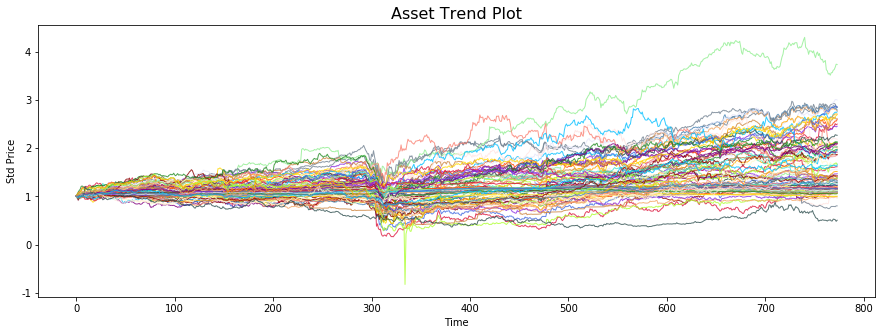

In [29]:
graph_time_series_plot(data, "Asset")

#### Calculate excess return

##### <font color="cornflowerblue">Adjust the "comd_CL=F" because it occurs negative value in history</font>

In [30]:
data.loc[(data["comd_CL=F"] < 0), "comd_CL=F"] = 0.01
display(data.head(2))

,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,us_WAT,us_CI,us_LMT,us_CHRW,us_IRM,...,comd_BZ=F,comd_AUP=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE,comd_BCI
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,838.340027,103.629318,39.400043,165.585190,84.221062,188.649994,186.476883,241.550751,77.960831,26.069143,...,52.279999,0.191180,5.930000,16.049999,16.180000,37.450001,24.709999,13.551000,12.219778,17.503473
2019-01-02,838.479980,101.673889,39.336224,165.497498,84.842529,183.410004,183.776733,244.216827,76.931740,25.819796,...,54.910000,0.191180,5.980000,16.120001,16.379999,36.630001,24.490000,13.395667,12.318008,17.470907


##### Empirical return

In [31]:
def cal_empirical_return(df: pd.DataFrame):
    """
    Calculate the empirical return of the assets.
    """
    df = df.copy()
    cols_data, cols_del = df.columns.tolist(), []
    for col in cols_data:
        if sum(pd.isna(df[col])) > 0:
            print(col)
            df.drop(col, axis=1, inplace=True)
            cols_del.append(col)
        else:
            df[col + "_return"] = df[col] / df[col].shift(1)
    df.dropna(inplace=True)
    for col in cols_del: cols_data.remove(col)
    
    for col in cols_data:
        df[col + "_return"] = np.log(df[col + "_return"])
    
    df.drop(cols_data, axis=1, inplace=True)
    df.columns = cols_data
    return df

In [32]:
data = cal_empirical_return(data) * 100
display(data.head(3))

,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,us_WAT,us_CI,us_LMT,us_CHRW,us_IRM,...,comd_BZ=F,comd_AUP=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE,comd_BCI
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.016693,-1.904976,-0.162111,-0.052973,0.735191,-2.816931,-1.458566,1.097687,-1.328800,-0.961090,...,4.908161,0.000000,0.839639,0.435199,1.228510,-2.213912,-0.894312,-1.152902,0.800650,-0.186228
2019-01-03,0.843210,-1.034060,-0.549045,-3.279588,-1.611095,-3.931018,-0.858508,-2.544074,-3.757345,1.576282,...,1.876297,-1.677349,0.832647,0.803212,0.487211,2.799637,-1.149913,-0.987771,1.189067,0.691929
2019-01-04,-1.183687,1.114513,2.536846,4.688521,1.998815,1.931995,1.667317,2.661106,3.407284,1.732838,...,1.964492,0.000000,0.496275,0.918840,1.087626,-0.772814,3.570363,2.317626,1.873597,1.118246


- **Return Distributions**

<font color='red'>The asset price are adjusted to a relative value by using the first value of the data series.</font>

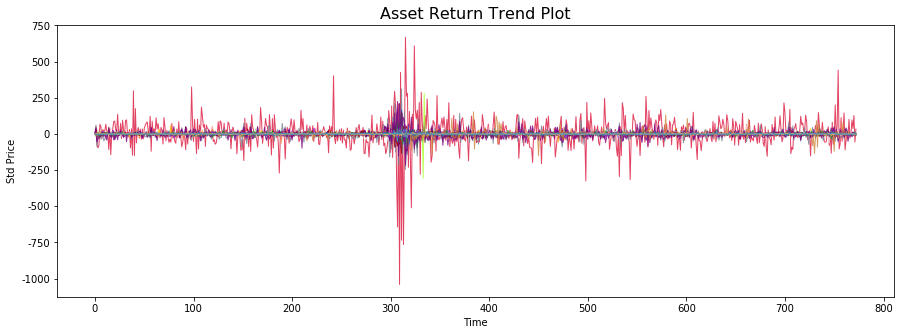

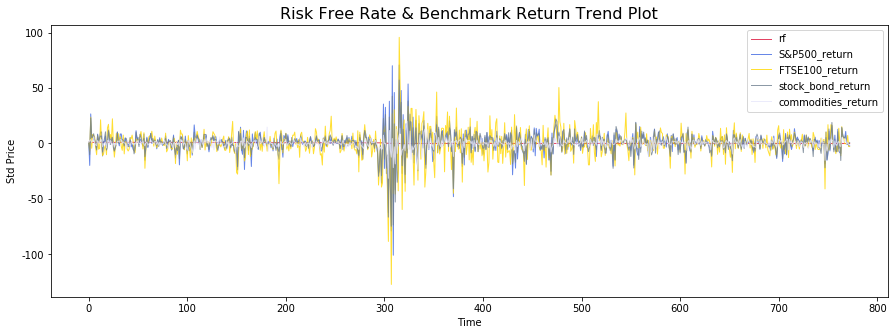

In [33]:
display(md("<font color='red'>The asset price are adjusted to a relative value by using the first value of the data series.</font>"))

# Asset plot
graph_time_series_plot(data, "Asset Return")

# Risk free rate & Benchmark plot
market_df = pd.concat(
                [risk_free_rate, SAP500, FTSE100, M_stock_bond, M_commodities], axis=1, join="outer"
            ).loc[:, ["rf", "S&P500_return", "FTSE100_return", "stock_bond_return", "commodities_return"]].fillna(method="ffill")
graph_time_series_plot(market_df, "Risk Free Rate & Benchmark Return", legend=True)

#### Calculate excess return

##### Estimate beta according to CAPM <font color="cornflowerblue">(linear regression)</font>

In [34]:
print("market_df: {}  data: {}".format(len(market_df), len(data)))
df1, df2 = market_df.copy().reset_index(), data.copy().reset_index()
df1["Date"], df2["Date"] = df1["Date"].astype(str), df2["Date"].astype(str)
all_data = pd.merge(df1, df2, on="Date", how="outer").fillna(method="ffill")

all_data["Date"] = pd.to_datetime(all_data["Date"])
all_data = all_data.set_index("Date")
print(len(all_data))
display(all_data.head(3))

market_df: 773  data: 773
773


,rf,S&P500_return,FTSE100_return,stock_bond_return,commodities_return,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,...,comd_BZ=F,comd_AUP=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE,comd_BCI
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.009276,0.126769,0.090625,0.087005,0.538253,0.016693,-1.904976,-0.162111,-0.052973,0.735191,...,4.908161,0.000000,0.839639,0.435199,1.228510,-2.213912,-0.894312,-1.152902,0.800650,-0.186228
2019-01-03,0.009237,-2.506833,-0.618164,-0.873368,1.446539,0.843210,-1.034060,-0.549045,-3.279588,-1.611095,...,1.876297,-1.677349,0.832647,0.803212,0.487211,2.799637,-1.149913,-0.987771,1.189067,0.691929
2019-01-04,0.009249,3.375940,2.139012,1.997460,1.872013,-1.183687,1.114513,2.536846,4.688521,1.998815,...,1.964492,0.000000,0.496275,0.918840,1.087626,-0.772814,3.570363,2.317626,1.873597,1.118246


In [35]:
del df1, df2

**Estimate beta**
According to CAPM:
$$
R_i=R_f+\beta_i(R_m-Rf)
$$
where:
- $R_i$: Return of the asset $i$.
- $R_f$: Risk free rate.
- $R_m$: Benchmark return.
- $\beta_i$: The systematic risk.
    
The linear regression is going to move the risk free rate on the right side to the left side, and use a linear regression without intercepter to estimate $\beta_i$. For simplicity, here <font color="sandybrown">assume the $\beta$ of an asset will not change with time passed.</font> But in reality, the $\beta$ changes. <font color="sandybrown">And the $beta$ be going to use here is under-estimated or smoothed owing to the long period of time.</font><br>
**<font color="red">Different benchmark is used in the calculation.</font>**

Adjusted with $R_f$

In [36]:
all_data["S&P500_return"] -= all_data["rf"]
all_data["FTSE100_return"] -= all_data["rf"]
all_data["stock_bond_return"] -= all_data["rf"]
all_data["commodities_return"] -= all_data["rf"]
for col in data.columns:
    all_data[col] -= all_data["rf"]
display(all_data.head(3))

,rf,S&P500_return,FTSE100_return,stock_bond_return,commodities_return,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,...,comd_BZ=F,comd_AUP=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE,comd_BCI
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.009276,0.117493,0.081349,0.077729,0.528977,0.007417,-1.914252,-0.171387,-0.062249,0.725915,...,4.898885,-0.009276,0.830363,0.425923,1.219234,-2.223189,-0.903588,-1.162178,0.791374,-0.195504
2019-01-03,0.009237,-2.516071,-0.627401,-0.882605,1.437302,0.833972,-1.043297,-0.558282,-3.288826,-1.620332,...,1.867060,-1.686587,0.823410,0.793975,0.477974,2.790399,-1.159150,-0.997008,1.179830,0.682692
2019-01-04,0.009249,3.366691,2.129763,1.988211,1.862764,-1.192935,1.105264,2.527597,4.679272,1.989566,...,1.955243,-0.009249,0.487026,0.909591,1.078377,-0.782063,3.561114,2.308377,1.864348,1.108997


In [37]:
from statsmodels.regression.linear_model import OLS

beta_df = pd.DataFrame(columns=["asset", "coefficient", "p value"])

for col in data.columns:
    # For commodity assets
    if re.match("comd_", col) is not None:
        x, y = all_data["commodities_return"], all_data[col]
    # For bond assets
    else:
        x, y = all_data["stock_bond_return"], all_data[col]
    
    # OLS
    cls = OLS(y, x)
    res = cls.fit()
    beta_df.loc[len(beta_df)] = [col, res.params[0], round(res.pvalues[0], 6)]
display(beta_df.head(3))
res = "The # of $beta>1$: {}, the # of $beta\leqslant1$: {}".format(len(beta_df[beta_df["coefficient"] > 1]), len(beta_df[beta_df["coefficient"] <= 1]))
display(md(res))

,asset,coefficient,p value
0,us_AZO,1.271112,0.000000
1,us_KMB,0.687725,0.000000
2,us_MO,1.119993,0.000000


The # of $beta>1$: 46, the # of $beta\leqslant1$: 39

In [38]:
beta_df[beta_df["p value"] > 0.05]

,asset,coefficient,p value
58,bond_BIL,0.000092,0.845067
63,bond_GBF,0.028491,0.054850
74,comd_CL=F,0.110670,0.864244
76,comd_AUP=F,0.047581,0.186935


- Remove assets with large p values

In [39]:
print("Before:", data.shape, all_data.shape)
for col in beta_df.loc[beta_df["p value"] > 0.1, "asset"].tolist():
    if col in data.columns: data.drop(col, axis=1, inplace=True)
    if col in all_data.columns: all_data.drop(col, axis=1, inplace=True)
print("After:", data.shape, all_data.shape)

Before: (773, 85) (773, 90)
After: (773, 82) (773, 87)


In [41]:
beta_info = beta_df[["asset", "coefficient"]].set_index("asset").to_dict()["coefficient"]

##### Calculate Excess Return according to CAPM

The formula for calculating the excess return:
$$
\text{Excess Return}=R_f+\beta_i(R_m-R_f)-TR
$$
where:
- TR: Total return
- $R_f$: Risk free rate.
- $R_m$: Benchmark return.
- $\beta_i$: The systematic risk.

In [42]:
ex_data = pd.DataFrame(index=data.index)
all_data = all_data.reset_index(drop=True).set_index(data.index)

for col in data.columns:
    # For commodity assets
    if re.match("comd_", col) is not None:
        ex_data[col] = all_data["rf"] + all_data["commodities_return"] * beta_info[col] - data[col]
    # For bond assets
    else:
        ex_data[col] = all_data["rf"] + all_data["stock_bond_return"] * beta_info[col] - data[col]
display(ex_data.head(3))

,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,us_WAT,us_CI,us_LMT,us_CHRW,us_IRM,...,comd_GC=F,comd_BZ=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE,comd_BCI
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.091386,1.967708,0.258443,0.201977,-0.597508,2.930918,1.607120,-0.993898,1.411089,1.072564,...,-0.178267,-4.199891,-0.740778,-0.323511,-1.135828,2.321813,1.051615,1.316983,-0.346656,0.376191
2019-01-03,-1.955862,0.436308,-0.430230,1.702229,0.162287,2.751274,-0.713738,1.480124,2.937526,-2.727491,...,-0.766611,0.032201,-0.579998,-0.515709,-0.251351,-2.522424,1.561358,1.417636,0.028528,-0.191741
2019-01-04,3.720174,0.262079,-0.300813,-1.105205,1.294919,0.755627,1.904480,-0.234330,-1.530451,0.890507,...,0.798765,0.506226,-0.171560,-0.548956,-0.784670,1.129363,-3.039847,-1.763237,-0.298300,-0.472718


#### Correlation - Pearson & Spearman

In [43]:
corr = ex_data.corr()

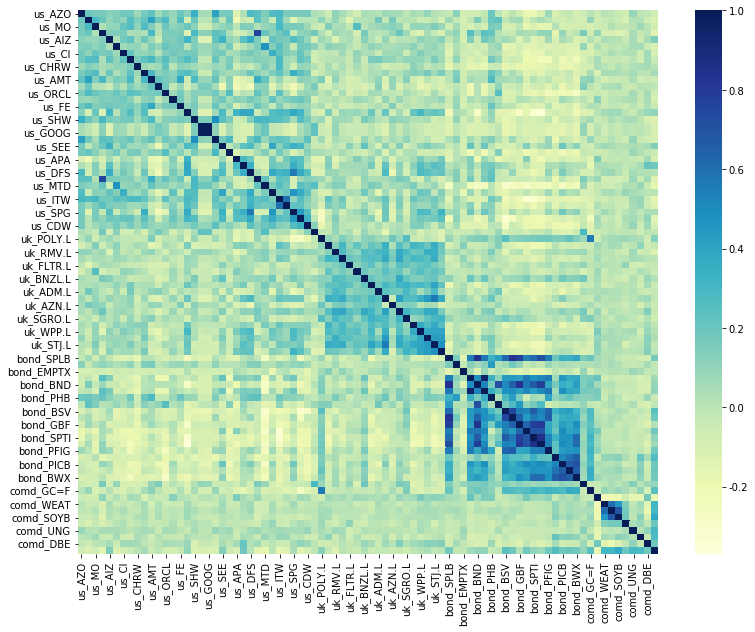

In [44]:
fig = plt.figure(figsize=(13, 10))
heatmap(corr, cmap="YlGnBu")

In [45]:
def filter_corr(corr_df: pd.DataFrame):
    """
    Filter the less correlated assets according to relative correlations.
    """
    col_stats = pd.DataFrame(columns=["cate", "asset", "corr_val"])
    for col in corr_df:
        corr_dataline = np.abs(np.array(corr_df[col]))
        col_stats.loc[len(col_stats)] = [col.split("_")[0], col, (sum(corr_dataline) - 1) / (len(corr_dataline) - 1)]

    threshold = col_stats.groupby("cate")[["corr_val"]].mean().reset_index().rename(columns={"corr_val": "threshold"})
    col_stats = pd.merge(col_stats, threshold, on="cate", how="left")
    display("Original col_stats", col_stats)
    col_stats = col_stats.loc[(col_stats["corr_val"] < col_stats["threshold"] * 1.1)]
    return col_stats

In [46]:
sel_assets = filter_corr(corr)

cols_sel = sel_assets["asset"].tolist()
print(cols_sel)

'Original col_stats'

,cate,asset,corr_val,threshold
0,us,us_AZO,0.101718,0.105595
1,us,us_KMB,0.095951,0.105595
2,us,us_MO,0.099518,0.105595
3,us,us_SPGI,0.110620,0.105595
4,us,us_AIZ,0.102308,0.105595
...,...,...,...,...
77,comd,comd_JO,0.040552,0.064855
78,comd,comd_UNG,0.041106,0.064855
79,comd,comd_JJC,0.052732,0.064855
80,comd,comd_DBE,0.063029,0.064855


['us_AZO', 'us_KMB', 'us_MO', 'us_SPGI', 'us_AIZ', 'us_WAT', 'us_CI', 'us_LMT', 'us_CHRW', 'us_IRM', 'us_AMT', 'us_CTXS', 'us_ORCL', 'us_NRG', 'us_FE', 'us_SHW', 'us_GOOGL', 'us_GOOG', 'us_HD', 'us_SEE', 'us_TGT', 'us_APA', 'us_MPC', 'us_MCO', 'us_HCA', 'us_CDW', 'us_ADSK', 'uk_POLY.L', 'uk_EVR.L', 'uk_RMV.L', 'uk_SKG.L', 'uk_FLTR.L', 'uk_IMB.L', 'uk_BNZL.L', 'uk_DCC.L', 'uk_ADM.L', 'uk_AZN.L', 'uk_FERG.L', 'uk_SGRO.L', 'uk_JMAT.L', 'bond_USHY', 'bond_EMPTX', 'bond_PHB', 'bond_SPMB', 'bond_PFIG', 'bond_BWZ', 'bond_WIP', 'bond_CWB', 'comd_BZ=F', 'comd_WEAT', 'comd_CORN', 'comd_SOYB', 'comd_JO', 'comd_UNG', 'comd_JJC', 'comd_DBE']


In [47]:
sel_data = ex_data[cols_sel]
display(sel_data.head())

,us_AZO,us_KMB,us_MO,us_SPGI,us_AIZ,us_WAT,us_CI,us_LMT,us_CHRW,us_IRM,...,bond_WIP,bond_CWB,comd_BZ=F,comd_WEAT,comd_CORN,comd_SOYB,comd_JO,comd_UNG,comd_JJC,comd_DBE
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.091386,1.967708,0.258443,0.201977,-0.597508,2.930918,1.607120,-0.993898,1.411089,1.072564,...,0.150941,0.150884,-4.199891,-0.740778,-0.323511,-1.135828,2.321813,1.051615,1.316983,-0.346656
2019-01-03,-1.955862,0.436308,-0.430230,1.702229,0.162287,2.751274,-0.713738,1.480124,2.937526,-2.727491,...,-0.864911,0.677263,0.032201,-0.579998,-0.515709,-0.251351,-2.522424,1.561358,1.417636,0.028528
2019-01-04,3.720174,0.262079,-0.300813,-1.105205,1.294919,0.755627,1.904480,-0.234330,-1.530451,0.890507,...,-0.156393,0.108046,0.506226,-0.171560,-0.548956,-0.784670,1.129363,-3.039847,-1.763237,-0.298300
2019-01-07,2.148437,-1.042720,3.547821,-0.034090,0.305468,-3.491022,1.928806,-0.620828,-0.079032,-0.547806,...,0.189183,-0.849301,0.111825,0.082880,0.093425,-0.162302,-1.423058,3.001555,0.414361,-0.165070
2019-01-08,1.989304,-1.011071,0.000373,0.002067,0.719266,-2.026339,-0.911759,-0.044498,-0.321220,-1.510965,...,0.521757,-0.164628,-0.461077,-0.237691,0.719210,0.900783,-2.037074,-1.048726,-0.187716,-0.670581


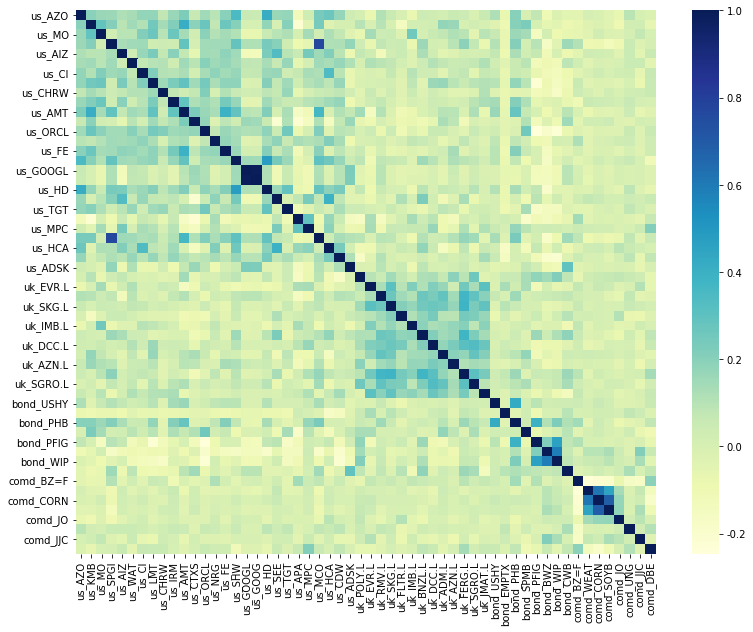

In [48]:
fig = plt.figure(figsize=(13, 10))
heatmap(sel_data.corr(), cmap="YlGnBu")

In [49]:
data = ex_data.copy()

In [95]:
data = sel_data.copy()

## 2. Marcenko-Pastur denoising

### Identify the sample noise

In [50]:
corr = data.corr()
corr.shape

(82, 82)

In [51]:
eg_val, eg_vec = np.linalg.eigh(corr)

indices = eg_val.argsort()[::-1]  # arguments for sorting eVal desc
eg_val, eg_vec = eg_val[indices], eg_vec[:, indices]

In [52]:
def graph_eigenvalue_bars(x: np.array, figsize=(15, 3)):
    """
    Graph the bar chart of the SORTED eigenvalues.
    """
    fig = plt.figure(figsize=figsize)
    plt.bar(np.arange(len(x)), x, color="sandybrown")
    plt.title("Sorted Eigenvalues", fontsize=20)
    plt.xlabel("Eigenvalue indices")
    plt.ylabel("Eigenvalue")
    plt.grid()
    plt.show()

def graph_eigenvalue_distributions(x: np.array, figsize=(15, 3), bins=50, min_range=0.2):
    """
    Graph the eigenvalue histogram.
    """
    fig = plt.figure(figsize=figsize)
    plt.hist(x, bins=bins, density=True, edgecolor="white", range=(min_range, max(x)))
    plt.title('Eigenvalue distribution')
    plt.grid()
    plt.show()

In [53]:
print(np.mean(eg_val))
print(np.percentile(eg_val, 0.25))

1.0
0.014113553910883665


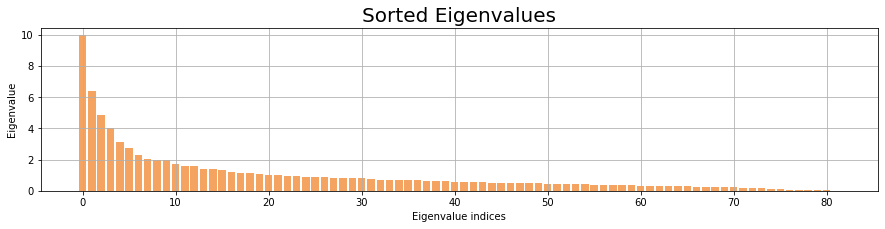

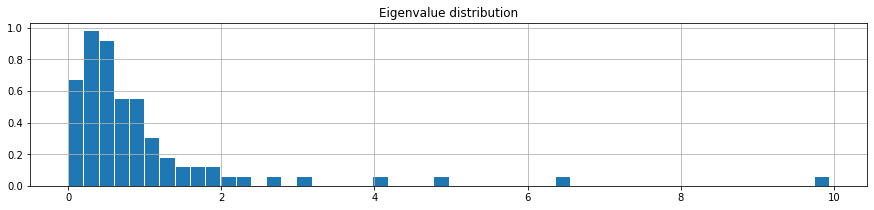

In [54]:
graph_eigenvalue_bars(eg_val)
graph_eigenvalue_distributions(eg_val, bins=50, min_range=0)

### Marchenko-Pastur Distribution

In [55]:
def mp_pdf(eg_val: np.array, var: float, T: int, N: int):
    """
    The Marchenko-Pastur distribution PDF.
    """
    q = T/N

    eg_min = var * (1 - np.sqrt(1. / q)) ** 2 
    eg_max = var * (1 + np.sqrt(1. / q)) ** 2

    pdf = (eg_max - eg_val) * (eg_val - eg_min)
    pdf[pdf<0] = 0
    pdf =  q / (2 * np.pi * var * eg_val) * np.sqrt(pdf)
    return pdf, eg_max

In [56]:
def graph_mpd_on_empirical_distrb(
    eg_val: np.array, 
    var: list, 
    time_steps: int, 
    num_assets: int,
    num_samples: int,
    color_list = ['lightpink', 'greenyellow', 'gold', 'orange', 'crimson', 'purple', 'royalblue', 'slategray', 'forestgreen', 'peru', 'salmon', 'darkred', 'black'],
    bins=50,
    min_range=0.2
):
    """
    Graph the Marchenko-Pastur distribution.
    """
    fig = plt.figure(figsize=(15, 5))
    for e, level in enumerate(var):
        x = np.linspace(0.001, int(max(eg_val)) + 1, num_samples)
        mp, _ = mp_pdf(eg_val=x, var=level, T=time_steps, N=num_assets)

        plt.plot(x, mp, color_list[e],label="theoretical var={:.1f}".format(level), alpha=0.8)
    plt.title("Eigenvalue distribution")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Probability density")
    plt.grid()
    plt.legend()
    plt.hist(eg_val, range=(min_range, max(eg_val)), bins=bins, density=True, label='sim', edgecolor="white")
    plt.show()

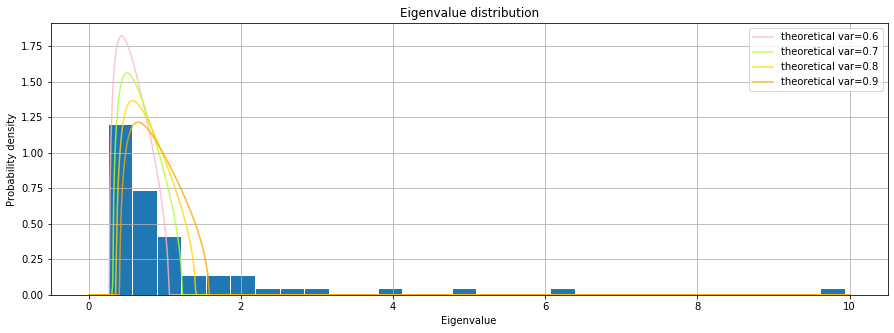

In [57]:
graph_mpd_on_empirical_distrb(
    eg_val,
    np.arange(0.6, 1, 0.1),
    len(data),
    corr.shape[0],
    10 * len(eg_val),
    bins=30,
    min_range=0.25
)

#### Search for a suitable var

In [58]:
def search_mp_var(T, N, eg_val):
    """
    Search for a suitable var for the estimation of MP distribution.
    """
    max_ll, max_var = -float("inf"), 0
    for var in np.linspace(0.01, 2, 200):
        mp, _ = mp_pdf(eg_val, var, T, N)
        mp[mp <= 0] = 1.0 / max(eg_val)
        ll = np.sum(np.log(mp))
        if ll > max_ll:
            max_ll = ll
            max_var = var
    return max_var

In [59]:
search_mp_var(len(data), corr.shape[0], eg_val)

0.59

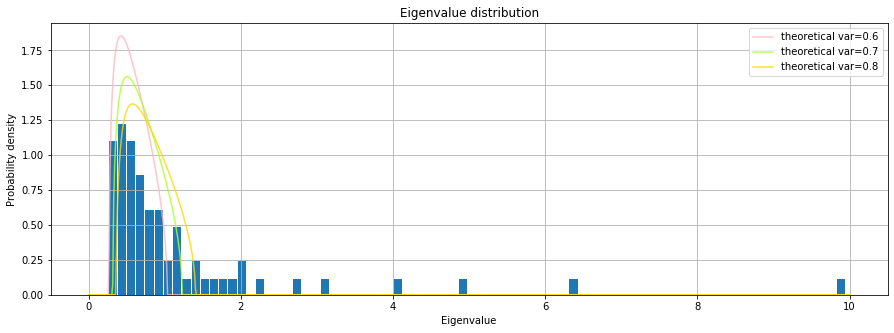

In [60]:
graph_mpd_on_empirical_distrb(
    eg_val,
    [0.59, 0.7, 0.8],
    len(data),
    corr.shape[0],
    10 * len(eg_val),
    bins=80,
    min_range=0.25
)

### Denoising

In [61]:
var_threshold = 0.59

In [62]:
_, val_threshold = mp_pdf(eg_val, var_threshold, len(data), corr.shape[0])
print("All eigenvalues below {:.3f} are considerd noise components, which will be replaced with their average.".format(val_threshold))

All eigenvalues below 1.037 are considerd noise components, which will be replaced with their average.


Original Distribution


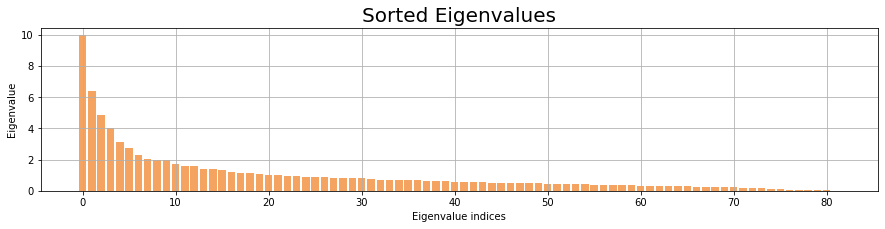

In [63]:
print("Original Distribution")
graph_eigenvalue_bars(eg_val)

New Distribution


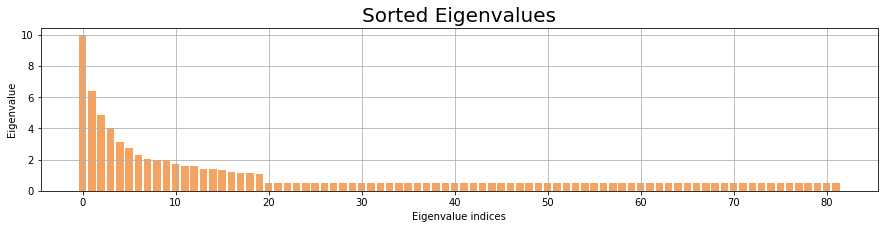

In [64]:
new_eg_val = eg_val.copy()
mask = new_eg_val < val_threshold
new_eg_val[mask] = np.mean(new_eg_val[mask])
print("New Distribution")
graph_eigenvalue_bars(new_eg_val)

In [65]:
def graph_compare_distributions(new_eg_val: np.array, old_eg_val: np.array):
    """
    Graph the eigenvalue distribution of the before denoising and after denoising.
    """
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    ax0.semilogy(old_eg_val, label="origin eigenvalue", color="cornflowerblue")
    ax1.semilogy(new_eg_val, label="denoted eigenvalue", color="orangered")
    ax1.semilogy(old_eg_val, label="origin eigenvalue", color="cornflowerblue")
    ax0.set_title("Origin eigenvalue")
    ax1.set_title("Denoted eigenvalue comparison")
    plt.legend()
    plt.show()

Using the var 0.59.


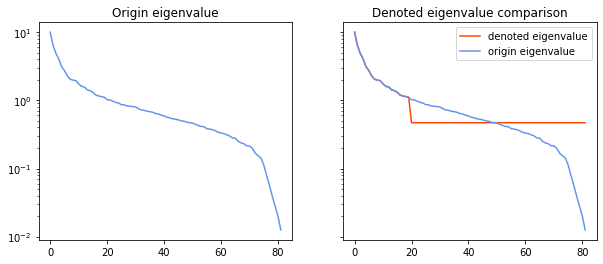

In [66]:
print("Using the var {}.".format(var_threshold))
graph_compare_distributions(new_eg_val, eg_val)

### Convert to covariance and correlation matrix

In [67]:
def denoisedCorr(eg_val: np.array, eg_vec: np.matrix, threshold: float):
    """
    Compute the correlation matrix that is denoised.
    """
    eg_val = np.diag(eg_val)
    corr = np.dot(eg_vec, eg_val).dot(eg_vec.T) 
    corr = cov2corr(corr)
    return corr

In [68]:
def graph_corr_matrix_compare(new_corr: pd.DataFrame, old_corr: pd.DataFrame):
    """
    Graph the correlation matrix of before transformation and after the transformation.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    img1 = axes[0].imshow(new_corr, cmap="YlGnBu")
    img2 = axes[1].imshow(old_corr, cmap="YlGnBu")
    axes[0].set_title("New correlation matrix")
    axes[1].set_title("Origin correlation matrix")
    axes[0].figure.colorbar(img1, ax=axes[0])
    axes[1].figure.colorbar(img2, ax=axes[1])
    plt.show()

## 3. Heatmap

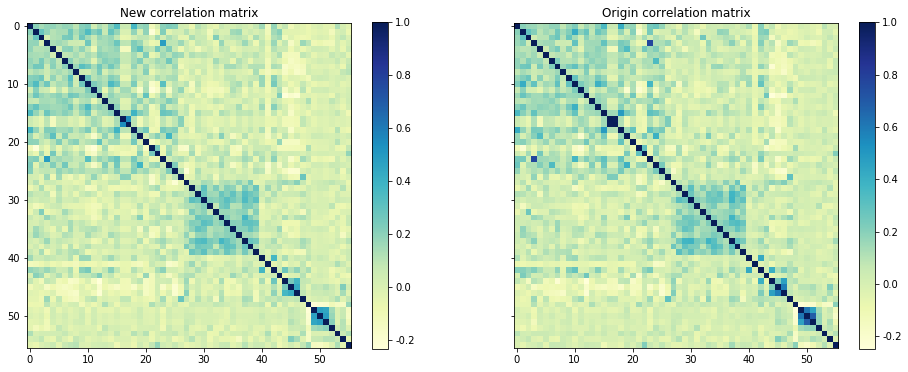

In [108]:
# 0.63 - portfolio with filtering the high correlated assets
new_corr_1 = denoisedCorr(new_eg_val, eg_vec, val_threshold)
graph_corr_matrix_compare(new_corr_1, corr)

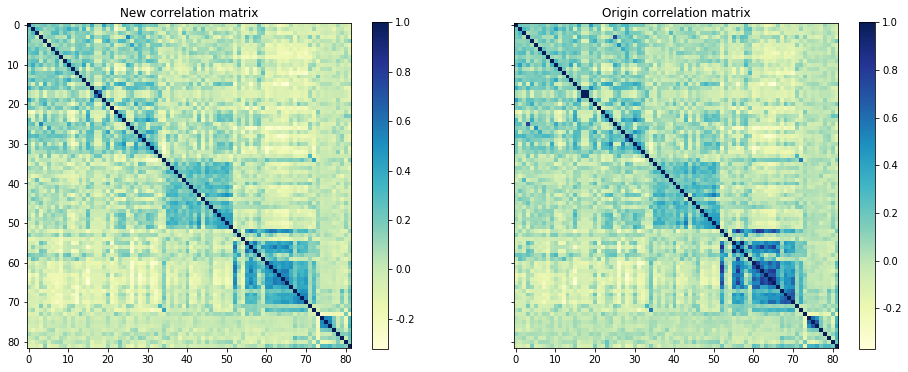

In [69]:
# 0.59
new_corr_1 = denoisedCorr(new_eg_val, eg_vec, val_threshold)
graph_corr_matrix_compare(new_corr_1, corr)

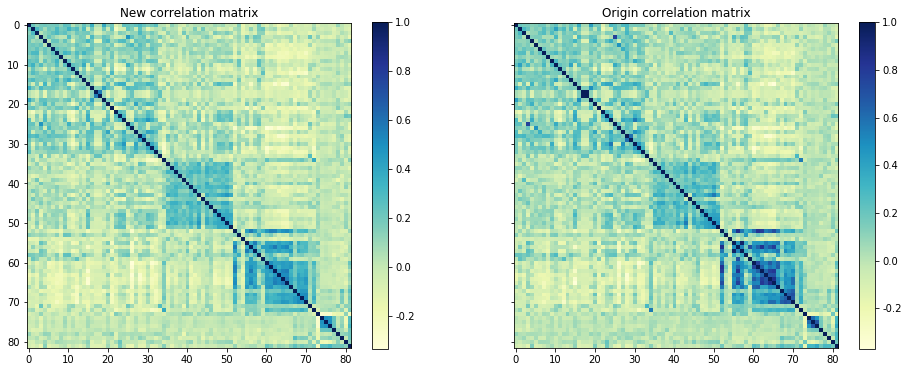

In [87]:
# 0.8
new_corr_2 = denoisedCorr(new_eg_val, eg_vec, val_threshold)
graph_corr_matrix_compare(new_corr_2, corr)

# Part II

In [70]:
print("T / N = {:.3f}".format(len(data) / corr.shape[0]))

T / N = 9.427


## 1. Black-Litterman Application

### Calculate the Equilibrium Return

The equilibrium returns are derived using a reverse optimization method in which the vector of implied excess equilibrium returns is extracted from known information using Formula:
$$
\Pi=\lambda\Sigma w_{mkt}
$$
where:
- $\Pi$: The implied excess equilibrium return.
- $\lambda$: The risk aversion coefficient.
- $\Sigma$: The covariance matrix of excess returns.
- $w_{mkt}$: The market capitalization weight of the assets.

##### Covariance matrix

In [71]:
std_arr = np.array([np.std(data[col]) for col in data.columns])
new_cov = corr2cov(new_corr_1, std_arr)
raw_cov = corr2cov(np.array(corr), std_arr)

##### Weighting vector

In [72]:
W_dict = asset_W_df.to_dict()["weights"]
W = []
for col in ex_data.columns:
    W.append(W_dict[col.split("_")[1]])
W = np.array(W).reshape(-1, 1)
W = [(i / sum(W))[0] for i in W]
print(len(W_dict))
print(len(W))

88
82


##### Equilibrium return

In [73]:
def graph_return_distribution(return_data: np.array, title=None, bins=30):
    """
    Graph the given return distribution.
    """
    plt.figure(figsize=(10, 3))
    plt.hist(return_data, bins=bins, edgecolor="white", color="forestgreen")
    plt.title("{}Return Distribution".format(title), fontsize=15)
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.show()

In [74]:
def compute_equilibrium_return(lambda_val: float, cov_matrix: np.matrix, weights: np.array):
    """
    Compute equilibrium return.
    """
    return lambda_val * np.dot(cov_matrix, weights)

In [75]:
equilibrium_return = compute_equilibrium_return(LAMBDA, new_cov, W)

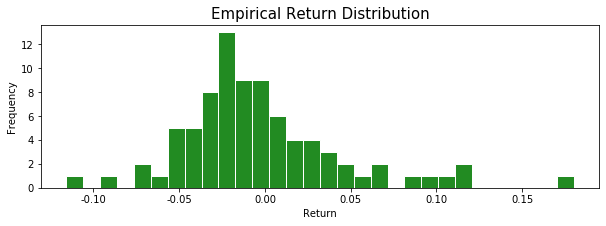

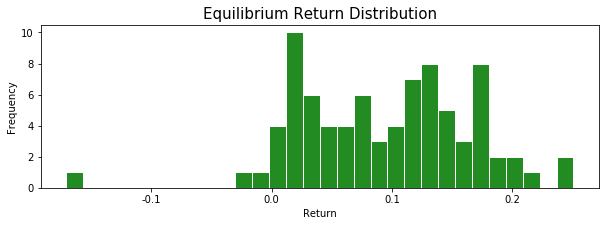

In [76]:
graph_return_distribution(np.mean(data, axis=0), "Empirical ")
graph_return_distribution(equilibrium_return, "Equilibrium ")

### Views

Because I have no access to analysts' reports towards assets, here simply using the recommendations from big banks as stocks' views, using the information got online to estimate the views towards bonds and commodities.
- Bond & commodity view: https://www.home.saxo/en-hk/content/articles/macro/market-quick-take-7-january-2022-07012022
    - CL=F: Brent resistance at 83 dollars followed by 85.50 dollars. The view is the coming return of brent oil should be 4.3% growth with condifence 60% because the situation all around the world as well as the decision made by OPEC.
    - GC=F: The now established triple top at $\$1830$ has weakened the technical outlook with support at $\$1783$ preventing an even deeper selloff. The view is the coming return of gold should be -0.7% owing to the strong economy and the raise of yield with 50% confidence.
    - SPLB: Ten-year yields approached the pivotal level of 1.75%. If they break above this level, they could rise fast to test 1.80%. The change of bond price owing to the change of interest rate should be calculated by modify duration, however, this is also not available. Thus, the estimated view is the coming return of long term bond should be -0.5% with confidence level 80%.
- Stocks:
    - Using the latest two week recommendations from large banks:
        - Strong Buy: $\mu+2\sigma$ growth with confidence 40%.
        - Buy: $\mu+\sigma$ growth with confidence 60%.
        - Sell: $\mu-\sigma$ growth with confidence 60%.
        - Strong Sell: $\mu-2\sigma$ growth with confidence 40%.
        - Others: No views.
        
<font color="sandybrown">The $\tau$ is adjusted according o the confidence level.</font>

In [77]:
BONDS_COMMODITIES = {
    "CL=F": [0.043, 0.6],
    "GC=F": [-0.007, 0.5],
    "SPLB": [-0.005, 0.8]
}
TRANSFER = {
    "Strong Buy": 2,
    "Buy": 1,
    "Sell": -1,
    "Strong Sell": -2
}
CONFIDENCE = {
    "Strong Buy": 0.5,
    "Buy": 0.7,
    "Sell": 0.7,
    "Strong Sell": 0.5
}
# TAU = 1 / len(data.columns)
TAU = 0.05
print("TAU:", TAU)

TAU: 0.05


##### Get stocks return

In [78]:
stocks_stats = {}
for col in data.columns:
    stocks_stats[col.split("_")[1]] = [np.mean(data[col]), np.std(data[col])]

In [79]:
def get_views_data(ticker: str):
    """
    Get views (recommendations) from yahoo.
    """
    views = yf.Ticker(ticker).get_recommendations()
    if views is None: return None
    views = views.reset_index()
    views = views.loc[(views["Date"] >= "2021-12-20") & (views["Date"] <= "2022-01-02"), ["Date", "To Grade"]]
    return views

def stock_views(views_df: pd.DataFrame, stock: str, stats: dict):
    """
    Calculate the stock views value.
    """
    mu, std = stats[stock]
    views_df["view"] = views_df["To Grade"].apply(lambda x: 
                                        (mu + std * TRANSFER.get(x, 0)) * np.abs(np.sign(TRANSFER.get(x, 0))))
    views_df["tau"] = views_df["To Grade"].apply(lambda x: 
                                        (TAU * CONFIDENCE.get(x, 0)) * np.sign(CONFIDENCE.get(x, 0)))
    return np.mean(views_df["view"]), np.mean(views_df["tau"])

def generate_views_matrix(df: pd.DataFrame, cov: np.array, stats: dict):
    """
    Generate views matrix.
    """
    cols = [col.split("_")[1] for col in df.columns]
    P, Q, tau = pd.DataFrame(columns=df.columns), [], []
    # Stocks
    for e, col in enumerate(tqdm(cols)):
        rec = get_views_data(col)
        if rec is None or len(rec) == 0: continue

        view_val, tau_val = stock_views(rec, col, stats)
        if np.sign(view_val) != 0:
            print("stock: {}  view_val: {}  tau_val: {}".format(col, view_val, tau_val))
            pline = [0] * len(cols)
            pline[e] = np.sign(view_val)
            P.loc[(len(P))] = pline
            Q.append(view_val)
            tau.append(tau_val)
    
    # Bonds & Commodities
    for item in ["CL=F", "GC=F", "SPLB"]:
        if item in cols:
            view_val, tau_val = BONDS_COMMODITIES.get(item)
            pline = [0] * len(cols)
            pline[cols.index(item)] = np.sign(view_val)
            P.loc[len(P)] = pline
            Q.append(view_val)
            tau.append(tau_val * TAU)

    return np.array(P), np.array(Q).reshape(-1, 1), np.array(tau).reshape(-1, 1)

def generate_error_cov(df: pd.DataFrame, cov: np.array, p_matrix: np.array, tau_vec: np.array):
    """
    Generate the views vector and the error covariance matrix.
    The error covariance is adjusted according to the confidence level.
    """
    cols = df.columns
    # Error variance
    omega = multi_dot([p_matrix, cov, p_matrix.T])
    omega = np.diag(np.diag(omega)) * np.diag(tau_vec.reshape(1, -1))
    return omega

In [80]:
# P, Q, tau = generate_views_matrix(data, new_cov, stocks_stats)

In [87]:
# omega = generate_error_cov(data, new_cov, P, tau)

In [88]:
# display(P)
# display(Q)
# display(tau)
# display(omega)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

array([[ 0.9830655 ],
       [ 1.01919707],
       [-0.007     ],
       [-0.005     ]])

array([[0.0175],
       [0.0175],
       [0.025 ],
       [0.04  ]])

array([[0.06330385, 0.        , 0.        , 0.        ],
       [0.        , 0.07266616, 0.        , 0.        ],
       [0.        , 0.        , 0.01835175, 0.        ],
       [0.        , 0.        , 0.        , 0.0154268 ]])

In [82]:
# print("P:", P.shape)
# print("view matrix:", Q.shape)
# print("error covariance matrix:", omega.shape)
# print("equibrium_return:", equilibrium_return.shape)

P: (4, 82)
view matrix: (4, 1)
error covariance matrix: (4, 4)
equibrium_return: (82,)


##### Store in a json file

In [90]:
test_dict = {"P": P.tolist(), "Q": Q.tolist(), "tau": tau.tolist(), "omega": omega.tolist()}

def store_dict(data_dict: dict, file_name: str):
    """
    Store a dictionary.
    """
    import json
    with open("test_dict.pkl", "w") as f:
        try:
            json.dump(data_dict, f)
        except:
            print("Error! Please turn the np.array format to list format.")
        f.close()

# store_dict(test_dict, "test_dict.pkl")

##### Read a json file

In [80]:
def read_simple_dict(file_name: str):
    import json
    with open(file_name, "r") as f:
        data_dict = json.load(f)
    data_dict = {k: np.array(v) for k, v in data_dict.items()}
    return data_dict

def read_complicated_dict(file_name: str):
    import json
    with open(file_name, "r") as f:
        data_dict = json.load(f)
    data_dict = {k: {k2: np.array(v2)} for k, v in data_dict.items() for k2, v2 in v.items()}
    return data_dict

In [81]:
test_dict = read_simple_dict("test_dict.pkl")
P, Q, tau, omega = test_dict["P"], test_dict["Q"], test_dict["tau"], test_dict["omega"]

### Black-Litterman Formula

The formula for the new **Combined Return Vector ($E(R)$)**:
$$
E(R)=[(\tau\Sigma)^{-1}+P^T\Omega^{-1}P]^{-1}[(\tau\Sigma)^{-1}\Pi+P^T\Omega^{-1}Q]
$$
where:
- $E(R)$: The new (posterior) combined return vector ($N\times1$ vector).
- $\Sigma$: The covariance matrix for the excess returns ($N\times N$ matrix).
- $\Pi$: The implied equilibrium return vector ($N\times 1$ vector).
- $\tau$: The scaler.
- $P$: The matrix that identifies the assets involved in the views ($K\times N$ matrix, where $K\in [1, \infty)$ represents the number of views).
- $\Omega$: The diagonal covariance matrix of error terms, to represent the uncertainty of the included views. (Calibrated by condifence level)
- $Q$: The view vector ($K\times 1$ vector).

#### Result dataframe

In [82]:
res_df = pd.DataFrame({
    "asset": data.columns,
    "return": equilibrium_return.reshape(1, -1)[0],
    "variance": np.diag(new_cov), 
    "weight": W
})
display(res_df.head(3))

,asset,return,variance,weight
0,us_AZO,0.173018,2.460411,0.009781
1,us_KMB,0.105044,1.816198,0.007540
2,us_MO,0.097558,2.267017,0.007540


#### Computationally stable formulation [Attillio Meucci (2010) suggested]
<font color="sandybrown">This project use the following formula to implement the calculation of posterior return.</font>
$$
\mu_{BL}=\Pi+\tau\Sigma P^T(\tau P\Sigma P^T+\Omega)^{-1}(Q-P\Pi)\\
\Sigma_{BL}=(1+\tau)\Sigma-\tau^2\Sigma P^T(\tau P\Sigma P^T+\Omega)^{-1}P\Sigma
$$

In [83]:
def compute_black_litterman_mu_cov(pi: np.array, cov_matrix: np.matrix, P: np.matrix, Q: np.array, omega: np.matrix):
    """
    Update the return and covariance matrix by using black litterman model.
    :params pi: The equilibrium return.
    :params cov_matrix: The covariance matrix.
    :params P: The matrix that identifies the assets involved in the views.
    :params Q: The view vector.
    :params omega: The diagonal covariance matrix of error terms.
    :returns: The posterior return vector and posterior covariance matrix.
    """
    same_part = multi_dot([
        cov_matrix,
        P.T,
        inv(TAU * multi_dot([P, cov_matrix, P.T]) + omega)
    ])
    mu_1 = pi
    mu_2 = TAU
    mu_3 = Q - np.dot(P, pi.reshape(-1, 1))
    cov_1 = (1 + TAU) * cov_matrix
    cov_2 = TAU ** 2
    cov_3 = np.dot(P, cov_matrix)
    
    posterior_mu = mu_1.reshape(-1, 1) + mu_2 * np.dot(same_part, mu_3)
    print("The Combined Return (posterior return) shape is {}".format(posterior_mu.shape))
    posterior_cov = cov_1 - cov_2 * np.dot(same_part, cov_3)
    print("The Combined Covariance (posterior covariance) shape is {}".format(posterior_cov.shape))
    return posterior_mu, posterior_cov

In [84]:
posterior_return, posterior_cov = compute_black_litterman_mu_cov(equilibrium_return, new_cov, P, Q, omega)

The Combined Return (posterior return) shape is (82, 1)
The Combined Covariance (posterior covariance) shape is (82, 82)


In [85]:
res_df["posterior return"] = posterior_return.reshape(1, -1)[0]
display(res_df.head(3))

,asset,return,variance,weight,posterior return
0,us_AZO,0.173018,2.460411,0.009781,0.377374
1,us_KMB,0.105044,1.816198,0.007540,0.147772
2,us_MO,0.097558,2.267017,0.007540,0.269269


### Optimization

In [86]:
print(sum(W))

0.9999999999999992


#### 1. Optimization without constraints
$$
\underset{x}{\operatorname{argmax}}w^T\mu_{BL}-\lambda w^T\Sigma w
$$
The solution for this problem is:
$$
w^*=\frac{1}{2\lambda}\hat{\Sigma}^{-1}\mu_{BL}
$$

In [87]:
def optimization_plane(mu: np.array, cov: np.matrix):
    """
    Calculate the plane optimization, without constraints, weightings.
    """
    return np.dot(inv(cov), mu) / (2 * LAMBDA)

In [88]:
plane_w = optimization_plane(posterior_return, new_cov)
print(plane_w.shape)
res_df["plane weight"] = plane_w
display(res_df)

(82, 1)


,asset,return,variance,weight,posterior return,plane weight
0,us_AZO,0.173018,2.460411,0.009781,0.377374,0.004891
1,us_KMB,0.105044,1.816198,0.007540,0.147772,0.003770
2,us_MO,0.097558,2.267017,0.007540,0.269269,0.003770
3,us_SPGI,0.167937,1.789036,0.014549,0.254806,0.007275
4,us_AIZ,0.133019,2.335389,0.014549,0.296210,0.007275
...,...,...,...,...,...,...
77,comd_JO,-0.012897,4.596007,0.002882,0.111734,0.001441
78,comd_UNG,0.179239,8.967623,0.009606,0.258143,0.004803
79,comd_JJC,0.017122,1.801953,0.017051,0.024740,0.008526
80,comd_DBE,0.063646,0.816255,0.045458,0.077907,0.022729


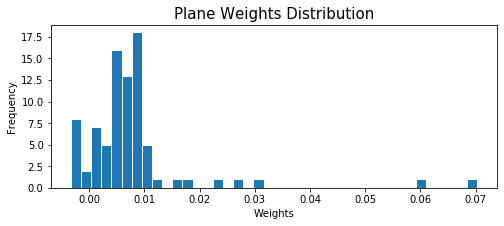

In [89]:
figure = plt.figure(figsize=(8, 3))
plt.hist(plane_w, bins=40, edgecolor="white")
plt.xlabel("Weights")
plt.ylabel("Frequency")
plt.title("Plane Weights Distribution", fontsize=15)
plt.show()

In [335]:
print(sum(plane_w)[0])

0.6264117896866905


#### 2. Max Sharpe Ratio (Tangency portfolio) optimization
$$
\underset{w}{\operatorname{arg max}}\frac{w^T\mu_{BL}-r_f}{\sqrt{w^T\Sigma w}}=\frac{\mu_{\Pi}-r_f}{\sigma_{\Pi}}
\\ \text{s.t. }w^T\mathbf{1}=1
$$
The solution for the optimization problem is:
$$
w^*=\frac{\Sigma^{-1}(\mu_{BL}-r_f\mathbf{1})}{\mathbf{1}^T\Sigma^{-1}(\mu_{BL}-r_f\mathbf{1})}
$$

In [91]:
def optimization_max_SR(cov: np.matrix, mu: np.array, r_f: float):
    """
    Calculate the weighting vector for the max sharpe ratio optimization.
    """
    one = np.ones(mu.shape[0]).reshape(-1, 1)
    numerator = np.dot(inv(cov), mu.reshape(-1, 1) - r_f * one)
    denominator = multi_dot([one.T, inv(cov), mu.reshape(-1, 1) - r_f * one])
    w = numerator / denominator
    return w

In [92]:
r_f = risk_free_rate.loc[(risk_free_rate.index.max()), "rf"]
print("risk free rate:", r_f)

risk free rate: 0.00013093086357329753


In [93]:
max_sr_w = optimization_max_SR(new_cov, posterior_return, r_f)
display(max_sr_w.shape)
res_df["max SR weight"] = max_sr_w
display(res_df)

(82, 1)

,asset,return,variance,weight,posterior return,plane weight,max SR weight
0,us_AZO,0.173018,2.460411,0.009781,0.377374,0.004891,0.007873
1,us_KMB,0.105044,1.816198,0.007540,0.147772,0.003770,0.006089
2,us_MO,0.097558,2.267017,0.007540,0.269269,0.003770,0.006085
3,us_SPGI,0.167937,1.789036,0.014549,0.254806,0.007275,0.011746
4,us_AIZ,0.133019,2.335389,0.014549,0.296210,0.007275,0.011738
...,...,...,...,...,...,...,...
77,comd_JO,-0.012897,4.596007,0.002882,0.111734,0.001441,0.002341
78,comd_UNG,0.179239,8.967623,0.009606,0.258143,0.004803,0.007747
79,comd_JJC,0.017122,1.801953,0.017051,0.024740,0.008526,0.013774
80,comd_DBE,0.063646,0.816255,0.045458,0.077907,0.022729,0.036596


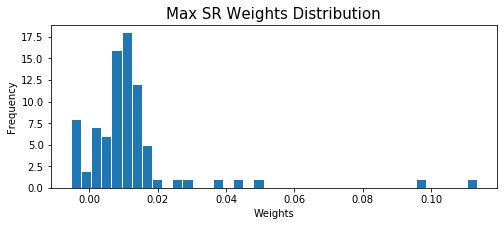

In [94]:
figure = plt.figure(figsize=(8, 3))
plt.hist(max_sr_w, bins=40, edgecolor="white")
plt.xlabel("Weights")
plt.ylabel("Frequency")
plt.title("Max SR Weights Distribution", fontsize=15)
plt.show()

In [95]:
print(sum(max_sr_w))

[1.]


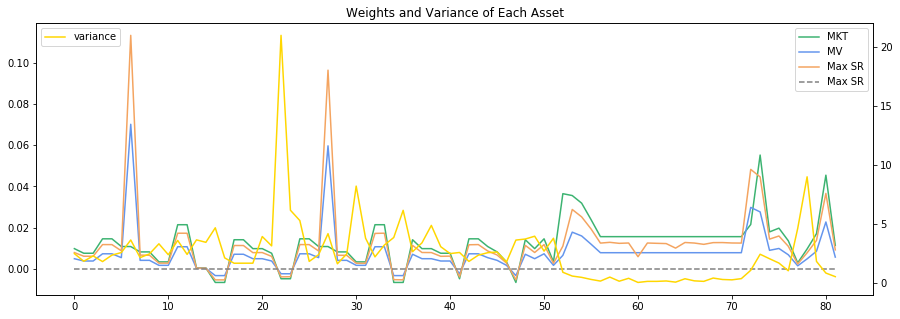

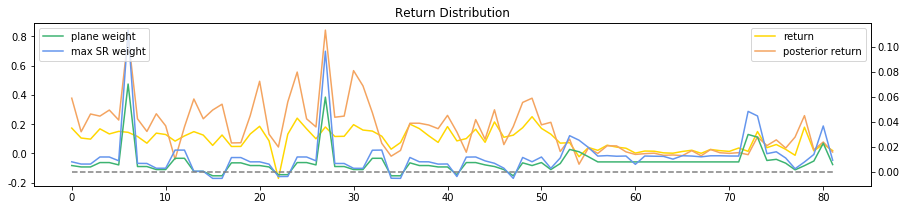

In [96]:
x = np.arange(len(res_df))
fig = plt.figure(figsize=(15, 5))
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax1.plot(x, np.array(res_df["weight"]), color="mediumseagreen", label="MKT")
ax1.plot(x, np.array(res_df["plane weight"]), color="cornflowerblue", label="MV")
ax1.plot(x, np.array(res_df["max SR weight"]), color="sandybrown", label="Max SR")
ax1.plot(x, np.array([0] * len(res_df)), color="grey", linestyle="--", label="Max SR")
ax1.legend(loc="upper right")
ax2.plot(x, np.array(res_df["variance"]), label="variance", color="gold")
ax2.legend(loc="upper left")
plt.title("Weights and Variance of Each Asset")
plt.xlabel("Asset Number")
plt.show()

fig = plt.figure(figsize=(15, 3))
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax1.plot(x, np.array(res_df["return"]), color="gold", label="return")
ax1.plot(x, np.array(res_df["posterior return"]), color="sandybrown", label="posterior return")
ax1.legend(loc="upper right")
ax2.plot(x, np.array(res_df["plane weight"]), label="plane weight", color="mediumseagreen")
ax2.plot(x, np.array(res_df["max SR weight"]), label="max SR weight", color="cornflowerblue")
ax2.plot(x, np.array([0] * len(res_df)), color="grey", linestyle="--")
ax2.legend(loc="upper left")
plt.title("Return Distribution")
plt.show()

In [97]:
display(res_df[res_df["max SR weight"] > 0.03])
display(res_df[res_df["weight"] > 0.03])

,asset,return,variance,weight,posterior return,plane weight,max SR weight
6,us_CI,0.144058,3.617365,0.010800,0.799344,0.070181,0.113378
27,us_HCA,0.180484,4.152357,0.010800,0.842398,0.059709,0.096467
72,comd_GC=F,0.014148,1.048671,0.021511,-0.008660,0.029803,0.048272
73,comd_BZ=F,0.149219,2.409355,0.055236,0.113203,0.027618,0.044603
80,comd_DBE,0.063646,0.816255,0.045458,0.077907,0.022729,0.036596


,asset,return,variance,weight,posterior return,plane weight,max SR weight
52,bond_SPLB,0.070145,0.881532,0.036468,0.013104,0.006508,0.010990
53,bond_USHY,0.073448,0.562002,0.035564,0.097946,0.017782,0.028800
54,bond_EMPTX,-0.022612,0.451236,0.031870,-0.073850,0.015935,0.025198
73,comd_BZ=F,0.149219,2.409355,0.055236,0.113203,0.027618,0.044603
80,comd_DBE,0.063646,0.816255,0.045458,0.077907,0.022729,0.036596


In [98]:
print("Average posterior return:", np.mean(res_df["posterior return"]))
print("Average variance:", np.mean(res_df["variance"]))
print("Average Sharp Ratio:", round((np.mean(res_df["posterior return"]) - r_f) / np.sqrt(np.mean(res_df["variance"])), 3))

Average posterior return: 0.1690151836368069
Average variance: 2.547043273619408
Average Sharp Ratio: 0.106


### Comparison

#### Portfolio return & variance compare

In [99]:
def compute_portfolio_return(rec_df: pd.DataFrame, return_type: str):
    """
    Compute the portfolio return.
    :params rec_df: The dataframe that contains all the computation result of the returns and weightings.
    :return: The return dictionary of the portfolio returns according to the optimization.
    """
    retn = np.array(rec_df[return_type]).reshape(-1, 1)
    mkt_weight = np.array(rec_df["weight"]).reshape(-1, 1)
    plane_weight = np.array(rec_df["plane weight"]).reshape(-1, 1)
    max_SR_weight = np.array(rec_df["max SR weight"]).reshape(-1, 1)
    equal_weight = np.array([1 / len(rec_df)] * len(rec_df)).reshape(-1, 1)
    # Compute portfolio return
    return_dict = {}
    weight_cate = ["mkt", "plane_MV", "max_SR", "equal"]
    for f, wt in enumerate([mkt_weight, plane_weight, max_SR_weight, equal_weight]):
        return_dict["{}".format(weight_cate[f])] = round(np.dot(retn.reshape(1, -1), wt).flat[0], 4)
    return return_dict

<font color="cornflowerblue">The result computed by using the raw return and posterior return are the same.</font>

In [100]:
return_dict = compute_portfolio_return(res_df, "posterior return")
for item, val in return_dict.items():
    print("The return of '{}' is {}%".format(item, val))

The return of 'mkt' is 0.1235%
The return of 'plane_MV' is 0.159%
The return of 'max_SR' is 0.2568%
The return of 'equal' is 0.169%


In [101]:
def compute_portfolio_var(rec_df: pd.DataFrame, cov_matrix: np.matrix):
    """
    Compute the portfolio variance.
    :params rec_df: The dataframe that contains all the computation result of the returns and weightings.
    :params cov_matrix: The covariance matrix of the portfolio.
    :return: The variance dictionary of the portfolio according to different weightings on assets.
    """
    name_change = {
        "weight": "mkt",
        "plane weight": "plane_MV",
        "max SR weight": "max_SR",
    }
    var_dict = {}
    for weight in ["weight", "plane weight", "max SR weight"]:
        weights = np.array(rec_df[weight]).reshape(-1, 1)
        portfolio_var = multi_dot([weights.T, cov_matrix, weights])
        var_dict[name_change[weight]] = round(portfolio_var.flat[0], 4)
    equal_w = np.array([1 / len(rec_df)] * len(rec_df)).reshape(-1, 1)
    var_dict["equal"] = round(multi_dot([equal_w.T, cov_matrix, equal_w]).flat[0], 4)
    return var_dict

In [102]:
var_dict = compute_portfolio_var(res_df, new_cov)
display(var_dict)

{'mkt': 0.0771, 'plane_MV': 0.071, 'max_SR': 0.1851, 'equal': 0.1426}

#### Portfolio Shape Ratio

In [103]:
display(r_f)

0.00013093086357329753

In [125]:
for key in return_dict.keys():
    retn, var = return_dict[key], var_dict[key]
    sr = round((retn - r_f) * 250 / np.sqrt(var * 250), 4)
    print("The {} Sharp Ratio is {}.".format(key, sr))

The mkt Sharp Ratio is 0.4443.
The plane_MV Sharp Ratio is 0.5962.
The max_SR Sharp Ratio is 0.5966.
The equal Sharp Ratio is 0.4472.


In [105]:
res = pd.DataFrame(
    index=["benchmark", "mean-variance", "max Sharp ratio", "Equally weighted"],
    columns=["return (%)", "volatility", "sharp ratio"]
)
res.loc[:, "return (%)"] = [0.1235, 0.159, 0.2568, 0.169]
res.loc[:, "volatility"] = [0.0771, 0.071, 0.1851, 0.1426]
res.loc[:, "sharp ratio"] = [7.025, 9.4271, 9.4328, 7.0707]
res["return (%)"] = res["return (%)"].apply(lambda x: x * 252)
res["volatility"] = res["volatility"].apply(lambda x: x * 252)
display(res)

,return (%),volatility,sharp ratio
benchmark,31.122000,19.429200,7.025000
mean-variance,40.068000,17.892000,9.427100
max Sharp ratio,64.713600,46.645200,9.432800
Equally weighted,42.588000,35.935200,7.070700


#### Weight distribution compare

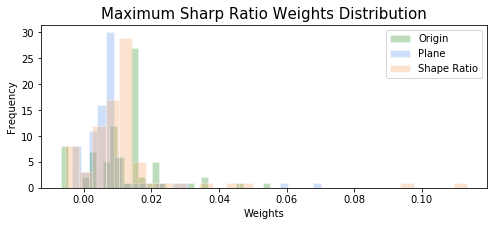

In [106]:
figure = plt.figure(figsize=(8, 3))
plt.hist(res_df["weight"], bins=30, edgecolor="white", color="forestgreen", alpha=0.3, label="Origin")
plt.hist(plane_w, bins=30, edgecolor="white", color="cornflowerblue", alpha=0.3, label="Plane")
plt.hist(max_sr_w, bins=30, edgecolor="white", color="sandybrown", alpha=0.3, label="Shape Ratio")
plt.legend()
plt.xlabel("Weights")
plt.ylabel("Frequency")
plt.title("Maximum Sharp Ratio Weights Distribution", fontsize=15)
plt.show()

## Simulation

In [120]:
SIMULATION = 1000000

def Monte_Carlo_simulation(return_df: np.array, cov: np.matrix):
    """
    Simulate the portfolio return, volatility, and corresponding weightings by using MC simulation.
    """
    from numpy.random import random
    returns, volatilities, weightings = [], [], []
    
    return_df = np.array(return_df).reshape(-1, 1)
    num_assets = return_df.shape[0]
    for i in range(SIMULATION):
        weights = random(num_assets).reshape(-1, 1)
        weights /= sum(weights)
        
        # Portfolio statistics
        returns.append(np.dot(weights.T, return_df).reshape(-1, 1))
        cov = np.sqrt(np.abs(cov)) * np.sign(cov)
        volatilities.append(np.sqrt(multi_dot([weights.T, cov, weights])))
        weightings.append(weights.flatten())
    return np.array(returns).flatten(), np.array(volatilities).flatten(), np.array(weightings).flatten()

In [121]:
posterior_return = np.array(res_df["posterior return"]).copy()
retns, vols, wts = Monte_Carlo_simulation(posterior_return, new_cov)

In [123]:
def graph_portfolio(
    volatility: list,
    returns: list,
    best_point: dict, 
    title="Monte Carlo Simulated Allocation"
):
    fig = plt.figure(figsize=(15, 6))
    ax = plt.axes()
    ax.set_title(title)
    
    fig.colorbar(ax.scatter(
        volatility, returns, c=returns / volatility,
        marker="o", cmap="RdYlGn", edgecolors="black"
    ), label="Sharpe Ratio")
    for k, v in best_point.items():
        ax.scatter(v["volatility"], v["return"], c=v["color"], marker="*", s=300, label=k)
    ax.set_xlabel("Expected Volatility")
    ax.set_ylabel("Expected Return")
    ax.legend()
    ax.grid(True)
    plt.show()

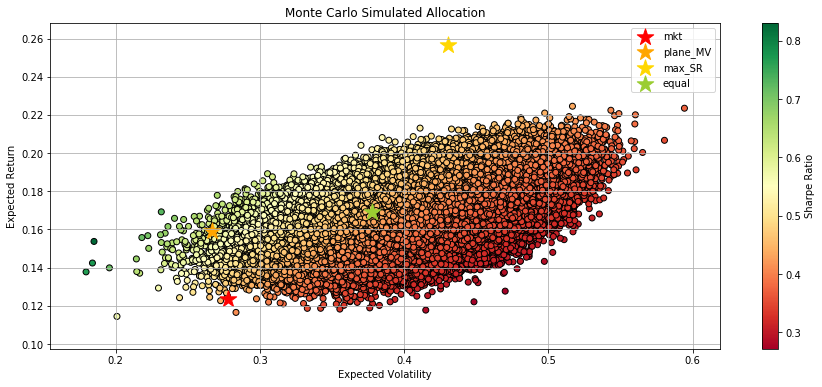

In [124]:
best_point = {
    "mkt": {"volatility": np.sqrt(var_dict["mkt"]), "return": return_dict["mkt"], "color": "red"},
    "plane_MV": {"volatility": np.sqrt(var_dict["plane_MV"]), "return": return_dict["plane_MV"], "color": "orange"},
    "max_SR": {"volatility": np.sqrt(var_dict["max_SR"]), "return": return_dict["max_SR"], "color": "gold"},
    "equal": {"volatility": np.sqrt(var_dict["equal"]), "return": return_dict["equal"], "color": "yellowgreen"}
}
graph_portfolio(vols, retns, best_point)

<font color="sandybrown">Since the Monte Carlo Simulation does not consider short selling situation, and there is shortselling positions in </font>

## Compare all situations

In [127]:
risk_appetite = {
    "Risk seeking": 0.005,
    "Risk neutral": 1.12,
    "Risk adverse": 3
}
cov_type = {
    0: "Naive covariance",
    1: "Robust covariance"
}
r_f = risk_free_rate.loc[(risk_free_rate.index.max()), "rf"]

In [117]:
# result_dict = {}
# for appetite in ["Risk seeking", "Risk neutral", "Risk adverse"]:
#     print("When the risk appetite is {}".format(appetite))
    
#     LAMBDA = risk_appetite[appetite]
#     for e, cov in enumerate([new_cov, raw_cov]):
#         print("Using the {}".format(cov_type[e]))
        
#         # Equilibrium return
#         equilibrium_return = compute_equilibrium_return(LAMBDA, cov, W)
#         # Matrix used in BL model
#         P, Q, tau = generate_views_matrix(data, cov, stocks_stats)
#         omega = generate_error_cov(data, cov, P, tau)
        
#         # Black Litterman model
#         res_df = pd.DataFrame({
#             "asset": data.columns,
#             "return": equilibrium_return.reshape(1, -1)[0],
#             "weight": W
#         })
#         posterior_return, posterior_cov = compute_black_litterman_mu_cov(equilibrium_return, cov, P, Q, omega)
#         res_df["posterior return"] = posterior_return.reshape(1, -1)[0]
        
#         # Plane weightings
#         plane_w = optimization_plane(posterior_return, cov)
#         res_df["plane weight"] = plane_w
        
#         # Max Sharpe Ratio weightings
#         max_sr_w = optimization_max_SR(cov * 252, posterior_return * 252, r_f)
#         res_df["max SR weight"] = max_sr_w
        
#         result_dict["{} - {}".format(appetite, cov_type[e])] = {
#             "cov": cov, "P": P, "Q": Q, "tau": tau, "omega": omega, "lambda": LAMBDA, 
#             "res_df": res_df, "equilibrium_return": equilibrium_return, "posterior_return": posterior_return
#         }

When the risk appetite is Risk seeking
Using the Naive covariance


stock: CI  view_val: 0.9830656921299131  tau_val: 0.017499999999999998
stock: HCA  view_val: 1.0191974341904464  tau_val: 0.017499999999999998

The Combined Return (posterior return) shape is (82, 1)
The Combined Covariance (posterior covariance) shape is (82, 82)
Using the Robust covariance


stock: CI  view_val: 0.9830656921299131  tau_val: 0.017499999999999998
stock: HCA  view_val: 1.0191974341904464  tau_val: 0.017499999999999998

The Combined Return (posterior return) shape is (82, 1)
The Combined Covariance (posterior covariance) shape is (82, 82)
When the risk appetite is Risk neutral
Using the Naive covariance


stock: CI  view_val: 0.9830656921299131  tau_val: 0.017499999999999998
stock: HCA  view_val: 1.0191974341904464  tau_val: 0.017499999999999998

The Combined Return (posterior return) shape is (82, 1)
The Combined Covariance (posterior covariance) shape is (82, 82)
Using the Robust covariance


stock: CI  view_val: 0.9830656921299131  tau_val: 0.017499999999999998
stock: HCA  view_val: 1.0191974341904464  tau_val: 0.017499999999999998

The Combined Return (posterior return) shape is (82, 1)
The Combined Covariance (posterior covariance) shape is (82, 82)
When the risk appetite is Risk adverse
Using the Naive covariance


stock: CI  view_val: 0.9830656921299131  tau_val: 0.017499999999999998
stock: HCA  view_val: 1.0191974341904464  tau_val: 0.017499999999999998

The Combined Return (posterior return) shape is (82, 1)
The Combined Covariance (posterior covariance) shape is (82, 82)
Using the Robust covariance


stock: CI  view_val: 0.9830656921299131  tau_val: 0.017499999999999998
stock: HCA  view_val: 1.0191974341904464  tau_val: 0.017499999999999998

The Combined Return (posterior return) shape is (82, 1)
The Combined Covariance (posterior covariance) shape is (82, 82)


##### Store the dictionary

In [128]:
import pickle

def store_dictionary_pkl(data_dict: dict, file_name: str):
    with open("data.pkl", "wb") as f:
        pickle.dump(data_dict, f)
        f.close()

def read_dictionary_pkl(file_name: str):
    with open(file_name, "rb") as f:
        data_dict = pickle.load(f)
        f.close()
    return data_dict

In [120]:
# store_dictionary_pkl(result_dict, "data.pkl")

##### Read the dictionary

In [129]:
compare_dict = read_dictionary_pkl("data.pkl")

In [130]:
display(compare_dict.keys())

dict_keys(['Risk seeking - Naive covariance', 'Risk seeking - Robust covariance', 'Risk neutral - Naive covariance', 'Risk neutral - Robust covariance', 'Risk adverse - Naive covariance', 'Risk adverse - Robust covariance'])

### Compare Navie & Robust Covariance

Here uses the risk neutral ($\lambda=1.12$), the risk appetite for *average investors* to do the comparison between navie and robust covariance. The rest two risk appetite are with the same logic.

In [131]:
naive_dict = compare_dict["Risk neutral - Naive covariance"]
robust_dict = compare_dict["Risk neutral - Robust covariance"]

In [132]:
naive_df = naive_dict["res_df"]
robust_df = robust_dict["res_df"]

#### Portfolio

In [133]:
names, index_val = ["naive", "robust"], []
comp_df = pd.DataFrame(columns=names)
for e, df in enumerate([naive_df, robust_df]):
    return_dict = compute_portfolio_return(df, "posterior return")
    var_dict = compute_portfolio_var(df, new_cov)
    sr = []
    for key in return_dict.keys():
        retn, var = return_dict[key], var_dict[key]
        sr.append(round((retn - r_f) * 252 / np.sqrt(var * 252), 4))
    
    index_val = ["{}_{}".format("return", i) for i in return_dict.keys()] + ["{}_{}".format("variance", i) for i in var_dict.keys()] + ["{}_{}".format("sharp ratio", i) for i in var_dict.keys()]
    comp_df[names[e]] = list(return_dict.values()) + list(var_dict.values()) + sr
comp_df["item"] = index_val
comp_df.set_index("item", inplace=True)
comp_df["difference"] = comp_df["naive"] - comp_df["robust"]
display(comp_df)

,naive,robust,difference
item,,,
return_mkt,0.123500,0.121400,0.002100
return_plane_MV,0.159000,0.155200,0.003800
return_max_SR,0.253800,0.253000,0.000800
return_equal,0.169000,0.160000,0.009000
variance_mkt,0.077100,0.077100,0.000000
variance_plane_MV,0.071000,0.068000,0.003000
variance_max_SR,0.180900,0.180600,0.000300
variance_equal,0.142600,0.142600,0.000000
sharp ratio_mkt,7.053100,6.933000,0.120100


#### Each category of assets

In [134]:
cols = pd.MultiIndex.from_tuples([
    ("naive", "us stock"), ("naive", "uk stock"), ("naive", "bond"), ("naive", "commodity"),
    ("robust", "us stock"), ("robust", "uk stock"), ("robust", "bond"), ("robust", "commodity")
])
names_map = {"us": "us stock", "uk": "uk stock", "bond": "bond", "comd": "commodity"}

names, index_val = ["naive", "robust"], []
cate_comp_df = pd.DataFrame(columns=cols)
for e, df in enumerate([naive_df, robust_df]):
    df = df.set_index("asset")
    for asset_cate in ["us_", "uk_", "bond_", "comd_"]:
        sub_df = df.filter(regex=asset_cate, axis=0)
        return_dict = compute_portfolio_return(sub_df, "posterior return")
        var_dict = compute_portfolio_var(sub_df, np.array(data.filter(regex=asset_cate, axis=1).cov()))
        sr = []
        for key in return_dict.keys():
            retn, var = return_dict[key], var_dict[key]
            sr.append(round((retn - r_f) / np.sqrt(var), 4))

        cate_comp_df[(names[e], names_map[asset_cate[:-1]])] = list(return_dict.values()) + list(var_dict.values()) + sr
        if index_val == []: index_val = ["{}_{}".format("return", i) for i in return_dict.keys()] + ["{}_{}".format("variance", i) for i in var_dict.keys()] + ["{}_{}".format("sharp ratio", i) for i in var_dict.keys()]
cate_comp_df["item"] = index_val
cate_comp_df.set_index("item", inplace=True)

for col in names_map.values():
    cate_comp_df[("difference", col)] = cate_comp_df[("robust", col)] - cate_comp_df[("naive", col)]
display(cate_comp_df)

naive                               robust           \
                     us stock uk stock     bond commodity us stock uk stock   
item                                                                          
return_mkt           0.075700 0.027400 0.004200  0.016200 0.074500 0.025900   
return_plane_MV      0.135400 0.013700 0.001900  0.007900 0.132000 0.012900   
return_max_SR        0.216200 0.021900 0.003100  0.012700 0.215100 0.021100   
return_equal         0.285800 0.177400 0.009100  0.076900 0.271800 0.164600   
variance_mkt         0.036500 0.013900 0.012900  0.011900 0.036500 0.013900   
variance_plane_MV    0.062600 0.003500 0.002300  0.003800 0.059500 0.003500   
variance_max_SR      0.159600 0.008900 0.005800  0.009700 0.157900 0.009300   
variance_equal       0.437900 0.793300 0.080000  0.346400 0.437900 0.793300   
sharp ratio_mkt      0.395500 0.231300 0.035800  0.147300 0.389300 0.218600   
sharp ratio_plane_MV 0.540600 0.229400 0.036900  0.126000 0.540600 0.215800   
sharp ratio_max_SR   0.540800 0.230800 0.039000  0.127600 0.541000 0.217400   
sharp ratio_equal    0.431700 0.199000 0.031700  0.130400 0.410500 0.184700   

                                        difference                      \
                         bond commodity   us stock  uk stock      bond   
item                                                                     
return_mkt           0.005100  0.016000  -0.001200 -0.001500  0.000900   
return_plane_MV      0.002300  0.008000  -0.003400 -0.000800  0.000400   
return_max_SR        0.003800  0.013000  -0.001100 -0.000800  0.000700   
return_equal         0.011800  0.067600  -0.014000 -0.012800  0.002700   
variance_mkt         0.012900  0.011900   0.000000  0.000000  0.000000   
variance_plane_MV    0.002100  0.003400  -0.003100  0.000000 -0.000200   
variance_max_SR      0.005700  0.009100  -0.001700  0.000400 -0.000100   
variance_equal       0.080000  0.346400   0.000000  0.000000  0.000000   
sharp ratio_mkt      0.043800  0.145500  -0.006200 -0.012700  0.008000   
sharp ratio_plane_MV 0.047300  0.135000   0.000000 -0.013600  0.010400   
sharp ratio_max_SR   0.048600  0.134900   0.000200 -0.013400  0.009600   
sharp ratio_equal    0.041300  0.114600  -0.021200 -0.014300  0.009600   

                                
                     commodity  
item                            
return_mkt           -0.000200  
return_plane_MV       0.000100  
return_max_SR         0.000300  
return_equal         -0.009300  
variance_mkt          0.000000  
variance_plane_MV    -0.000400  
variance_max_SR      -0.000600  
variance_equal        0.000000  
sharp ratio_mkt      -0.001800  
sharp ratio_plane_MV  0.009000  
sharp ratio_max_SR    0.007300  
sharp ratio_equal    -0.015800

### Optimal allocation v.s. benchmark & Allocation shift

#### Optimal allocations

In [135]:
output_name = [
    ("return", "raw", "Max SR"), ("return", "raw", "MV"), ("return", "raw", "Benchmark"), ("return", "raw", "equal"), 
    ("return", "diff", "SR - BM"), ("return", "diff", "MV - BM"), ("return", "diff", "SR - E"), ("return", "diff", "MV - E"),
    ("Volatility", "raw", "Max SR"), ("Volatility", "raw", "MV"), ("Volatility", "raw", "Benchmark"), ("Volatility", "raw", "equal"), 
    ("Volatility", "diff", "SR - BM"), ("Volatility", "diff", "MV - BM"), ("Volatility", "diff", "SR - E"), ("Volatility", "diff", "MV - E"),
    ("Sharp", "raw", "Max SR"), ("Sharp", "raw", "MV"), ("Sharp", "raw", "Benchmark"), ("Sharp", "raw", "equal"), 
    ("Sharp", "diff", "SR - BM"), ("Sharp", "diff", "MV - BM"), ("Sharp", "diff", "SR - E"), ("Sharp", "diff", "MV - E"),
    ("weight", "raw", "Max SR"), ("weight", "raw", "MV"), ("weight", "raw", "Benchmark"), ("weight", "raw", "equal"), 
    ("weight", "diff", "SR - BM"), ("weight", "diff", "MV - BM"), ("weight", "diff", "SR - E"), ("weight", "diff", "MV - E")
]

In [138]:
def compute_return_volatility_sharp(
    df: pd.DataFrame, 
    cov: np.matrix, 
    return_name: str, 
    weight_names: list, 
    equal_weight: list
):
    """
    Compute the return, volatility, and Shap ratio of the given dataframe (portfolio).
    :return: Two lists, one list of return, volatility, shap ratio, the other about the items name.
    """
    w_bm, w_e = np.array(df[weight_names[0]]).reshape(-1, 1), np.array([equal_weight[:len(df)]]).reshape(-1, 1)
    w_mv, w_sr = np.array(df[weight_names[1]]).reshape(-1, 1), np.array(df[weight_names[2]]).reshape(-1, 1)
    eqlb_retn, vol = np.array(df[return_name]).reshape(-1, 1), np.array(data.filter(regex=asset_cate, axis=1).cov())
    
    # Weight
    w_diff_sr, w_diff_mv, w_diff_esr, w_diff_emv = w_sr - w_bm, w_mv - w_bm, w_sr - w_e, w_mv - w_e

    # Return
    bm_retn, e_retn= np.dot(w_bm.T, eqlb_retn), np.dot(w_e.T, eqlb_retn)
    mv_retn, sr_retn = np.dot(w_mv.T, eqlb_retn), np.dot(w_sr.T, eqlb_retn)
    retn_diff_sr, retn_diff_mv = sr_retn - bm_retn, mv_retn - bm_retn
    retn_diff_esr, retn_diff_emv = sr_retn - e_retn, mv_retn - e_retn
    
    # Volatility
    bm_vol, e_vol = multi_dot([w_bm.T, cov, w_bm]), multi_dot([w_e.T, cov, w_e])
    mv_vol, sr_vol = multi_dot([w_mv.T, cov, w_mv]), multi_dot([w_sr.T, cov, w_sr])
    vol_diff_mv, vol_diff_sr = mv_vol - bm_vol, sr_vol - bm_vol
    vol_diff_emv, vol_diff_esr = mv_vol - e_vol, sr_vol - e_vol
    
    # Sharp ratio
    bm_sr, e_sr = (bm_retn - r_f) * 250 / np.sqrt(bm_vol * 250), (e_retn - r_f) * 250 / np.sqrt(e_vol * 250)
    mv_sr, sr_sr = (mv_retn - r_f) * 250 / np.sqrt(mv_vol * 250), (sr_retn - r_f) * 250 / np.sqrt(sr_vol * 250)
    sr_diff, mv_diff, esr_diff, emv_diff = sr_sr - bm_sr, mv_sr - bm_sr, sr_sr - e_sr, mv_sr - e_sr
    
    res_list = [
        sr_retn, mv_retn, bm_retn, e_retn, retn_diff_sr, retn_diff_mv, retn_diff_esr, retn_diff_emv,
        sr_vol, mv_vol, bm_vol, e_vol, vol_diff_sr, vol_diff_mv, vol_diff_esr, vol_diff_emv,
        sr_sr, mv_sr, bm_sr, e_sr, sr_diff, mv_diff, esr_diff, emv_diff, 
        sum(w_sr), sum(w_mv), sum(w_bm), sum(w_e), sum(w_diff_sr), sum(w_diff_mv), sum(w_diff_esr), sum(w_diff_emv)
    ]
    name_list = output_name
    return [i.flat[0] for i in res_list], name_list

In [139]:
df = robust_df.set_index("asset").copy()
equal_weight = np.array([1 / len(df)] * len(df)).reshape(-1, 1)
weight_names = ["weight", "plane weight", "max SR weight"]
oa_bm_comp = pd.DataFrame(columns=pd.MultiIndex.from_tuples(output_name))
for asset_cate in ["us_", "uk_", "bond_", "comd_"]:
    sub_df = df.filter(regex=asset_cate, axis=0)
    vol = np.array(data.filter(regex=asset_cate, axis=1).cov())
    res_list, _ = compute_return_volatility_sharp(
        sub_df, cov=vol, return_name="posterior return", weight_names=weight_names, equal_weight=equal_weight
    )
    oa_bm_comp.loc[len(oa_bm_comp)] = res_list
oa_bm_comp.index = ["us stock", "uk stock", "bond", "commodity"]

res_list, _ = compute_return_volatility_sharp(df, new_cov, "posterior return", weight_names, equal_weight)
oa_bm_comp.loc["portfolio"] = res_list

oa_bm_comp = oa_bm_comp.T
display(oa_bm_comp)

us stock  uk stock      bond  commodity  portfolio
return     raw  Max SR     0.215144  0.021090  0.003803   0.012964   0.253001
                MV         0.132011  0.012941  0.002333   0.007955   0.155240
                Benchmark  0.074475  0.025882  0.005067   0.015992   0.121416
                equal      0.112706  0.036122  0.002889   0.008246   0.159962
           diff SR - BM    0.140668 -0.004791 -0.001264  -0.003028   0.131584
                MV - BM    0.057536 -0.012941 -0.002734  -0.008038   0.033824
                SR - E     0.102437 -0.015032  0.000914   0.004719   0.093038
                MV - E     0.019305 -0.023181 -0.000556  -0.000291  -0.004722
Volatility raw  Max SR     0.157915  0.009262  0.005684   0.009135   0.180579
                MV         0.059455  0.003487  0.002140   0.003440   0.067988
                Benchmark  0.036495  0.013949  0.012851   0.011851   0.077131
                equal      0.075292  0.038226  0.004759   0.005152   0.142649
           diff SR - BM    0.121420 -0.004687 -0.007167  -0.002715   0.103447
                MV - BM    0.022960 -0.010462 -0.010711  -0.008411  -0.009144
                SR - E     0.082623 -0.028964  0.000925   0.003984   0.037930
                MV - E    -0.015837 -0.034739 -0.002619  -0.001712  -0.074661
Sharp      raw  Max SR     8.555034  3.443392  0.770061   2.122956   9.408786
                MV         8.551751  3.429836  0.752655   2.109313   9.405717
                Benchmark  6.153204  3.447364  0.688460   2.303774   6.904991
                equal      6.486918  2.910612  0.632036   1.787575   6.691098
           diff SR - BM    2.401831 -0.003972  0.081601  -0.180819   2.503795
                MV - BM    2.398547 -0.017528  0.064195  -0.194461   2.500726
                SR - E     2.068116  0.532780  0.138024   0.335381   2.717688
                MV - E     2.064832  0.519224  0.120618   0.321739   2.714620
weight     raw  Max SR     0.424468  0.095478  0.284997   0.195057   1.000000
                MV         0.260453  0.058585  0.174916   0.119687   0.613641
                Benchmark  0.291110  0.117170  0.377415   0.214305   1.000000
                equal      0.414634  0.219512  0.243902   0.121951   1.000000
           diff SR - BM    0.133357 -0.021692 -0.092418  -0.019248   0.000000
                MV - BM   -0.030657 -0.058585 -0.202499  -0.094618  -0.386359
                SR - E     0.009834 -0.124034  0.041095   0.073106  -0.000000
                MV - E    -0.154181 -0.160927 -0.068987  -0.002264  -0.386359

#### Allocation shift

In [140]:
display(robust_df.head())

,asset,return,weight,posterior return,plane weight,max SR weight
0,us_AZO,0.163782,0.009781,0.339864,0.004891,0.007970
1,us_KMB,0.096389,0.007540,0.127690,0.003770,0.006144
2,us_MO,0.092851,0.007540,0.220949,0.003770,0.006144
3,us_SPGI,0.170983,0.014549,0.258673,0.007275,0.011856
4,us_AIZ,0.121753,0.014549,0.271397,0.007275,0.011856


In [173]:
LAMBDA = 1.12
plane_nw = optimization_plane(np.array(robust_df["return"]), new_cov)
max_sr_nw = optimization_max_SR(new_cov * 252, np.array(robust_df["return"]) * 252, r_f)

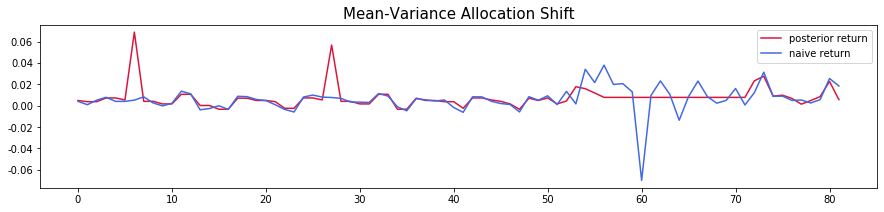

In [174]:
x = np.arange(len(robust_df))
plt.figure(figsize=(15, 3))
plt.plot(x, robust_df["plane weight"], color=color_list[0], label="posterior return")
plt.plot(x, plane_nw, color=color_list[1], label="naive return")
plt.title("Mean-Variance Allocation Shift", fontsize=15)
plt.legend()
plt.show()

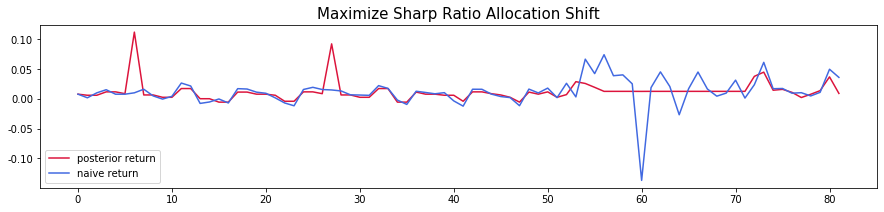

In [175]:
x = np.arange(len(robust_df))
plt.figure(figsize=(15, 3))
plt.plot(x, robust_df["max SR weight"], color=color_list[0], label="posterior return")
plt.plot(x, max_sr_nw, color=color_list[1], label="naive return")
plt.title("Maximize Sharp Ratio Allocation Shift", fontsize=15)
plt.legend()
plt.show()

### Three levels of risk aversion

In [181]:
display(compare_dict.keys())

dict_keys(['Risk seeking - Naive covariance', 'Risk seeking - Robust covariance', 'Risk neutral - Naive covariance', 'Risk neutral - Robust covariance', 'Risk adverse - Naive covariance', 'Risk adverse - Robust covariance'])

In [182]:
risk_averse_comp = pd.DataFrame(columns=pd.MultiIndex.from_tuples([
    ("return", "benchmark"), ("return", "equal"), ("return", "MV return"), ("return", "Max SR return"), 
    ("volatility", "benchmark"), ("volatility", "equal"), ("volatility", "MV return"), ("volatility", "Max SR return"),
    ("Sharp", "benchmark"), ("Sharp", "equal"), ("Sharp", "MV return"), ("Sharp", "Max SR return")
]))
indx = []
for ra in compare_dict.keys():
    if "Robust covariance" in ra:
        indx.append(ra.split(" - ")[0])
        df = compare_dict[ra].get("res_df").set_index("asset").copy()
        w, w_e = np.array(df["weight"]).reshape(-1, 1), equal_weight
        w_mv, w_sr = np.array(df["plane weight"]).reshape(-1, 1), np.array(df["max SR weight"]).reshape(-1, 1)
        retn, vol = np.array(df["posterior return"]).reshape(-1, 1), new_cov
        
        retn_raw, retn_e = np.dot(w.T, retn), np.dot(w_e.T, retn)
        retn_mv, retn_sr = np.dot(w_mv.T, retn), np.dot(w_sr.T, retn)
        vol_raw, vol_e = multi_dot([w.T, vol, w]), multi_dot([w_e.T, vol, w_e])
        vol_mv, vol_sr = multi_dot([w_mv.T, vol, w_mv]), multi_dot([w_sr.T, vol, w_sr])
        sr_raw, e_raw = (retn_raw - r_f) * 252 / np.sqrt(vol_raw * 252), (retn_e - r_f) * 252 / np.sqrt(vol_e * 252)
        sr_mv, sr_sr = (retn_mv - r_f) * 252 / np.sqrt(vol_mv * 252), (retn_sr - r_f) * 252 / np.sqrt(vol_sr * 252)
        
        res = [retn_raw, retn_e, retn_mv, retn_sr, vol_raw, vol_e, vol_mv, vol_sr, sr_raw, e_raw, sr_mv, sr_sr]
        risk_averse_comp.loc[len(risk_averse_comp)] = [i.flat[0] for i in res]
risk_averse_comp.index = indx
risk_averse_comp = risk_averse_comp.T
display(risk_averse_comp)

Risk seeking  Risk neutral  Risk adverse
return     benchmark          0.047964      0.121416      0.245265
           equal              0.085210      0.159962      0.286002
           MV return         24.450256      0.155240      0.146090
           Max SR return      0.618755      0.253001      0.289703
volatility benchmark          0.077131      0.077131      0.077131
           equal              0.142649      0.142649      0.142649
           MV return       2337.322195      0.067988      0.024446
           Max SR return      1.496891      0.180579      0.096134
Sharp      benchmark          2.734068      6.932556     14.011620
           equal              3.575933      6.717809     12.015322
           MV return          8.028272      9.443265     14.819183
           Max SR return      8.026613      9.446346     14.825776

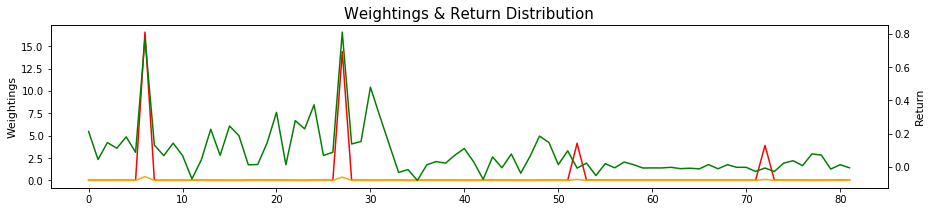

In [183]:
df = compare_dict["Risk seeking - Robust covariance"].get("res_df").set_index("asset").copy()
w_mv, w_sr = np.array(df["plane weight"]).reshape(-1, 1), np.array(df["max SR weight"]).reshape(-1, 1)
retn, vol = np.array(df["posterior return"]).reshape(-1, 1), new_cov
x = np.arange(len(w_mv))
_, ax = plt.subplots(figsize=(15, 3))
ax_ = ax.twinx()
ax.plot(x, w_mv, color="red")
ax.plot(x, w_sr, color="orange")
ax_.plot(x, retn, color="green")
plt.title("Weightings & Return Distribution", fontsize=15)
ax.set_ylabel("Weightings", fontsize=11)
ax_.set_ylabel("Return", fontsize=11)
plt.show()

In [184]:
risk_averse_comp.loc[("return", "equal")]

Risk seeking   0.085210
Risk neutral   0.159962
Risk adverse   0.286002
Name: (return, equal), dtype: float64

In [185]:
def graph_risk_adverse_trend(df: pd.DataFrame, item_name: str, return_names: list):
    x = ["risk seeking", "risk neutral", "risk adverse"]
    plt.figure(figsize=(12, 4))
    for i in range(len(return_names)):
        plt.plot(x, df.loc[(item_name, return_names[i])].tolist(), color=color_list[i], label=return_names[i])
    plt.legend()
    plt.title("Risk Adverse Change: {}".format(item_name), fontsize=15)
    plt.xlabel("Appetite")
    plt.ylabel("Value")
    plt.show()

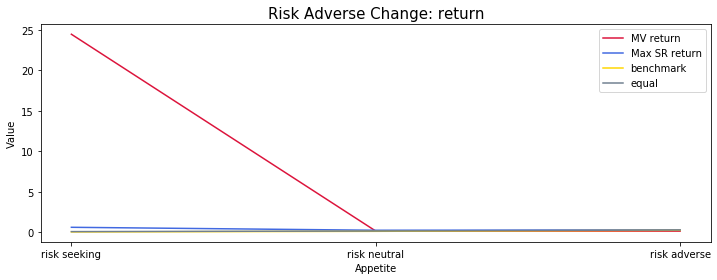

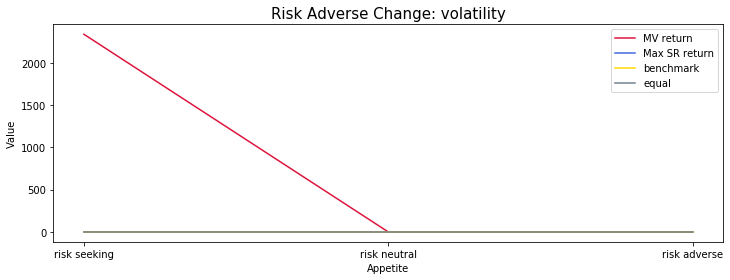

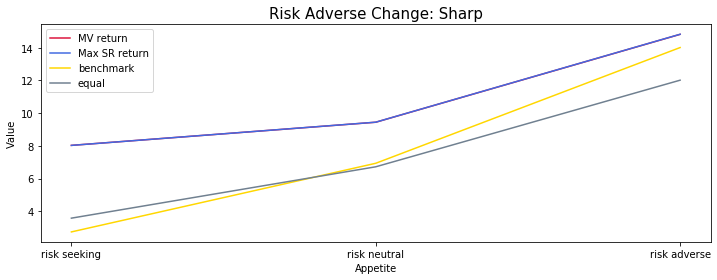

In [186]:
graph_risk_adverse_trend(risk_averse_comp, "return", ["MV return", "Max SR return", "benchmark", "equal"])
graph_risk_adverse_trend(risk_averse_comp, "volatility", ["MV return", "Max SR return", "benchmark", "equal"])
graph_risk_adverse_trend(risk_averse_comp, "Sharp", ["MV return", "Max SR return", "benchmark", "equal"])

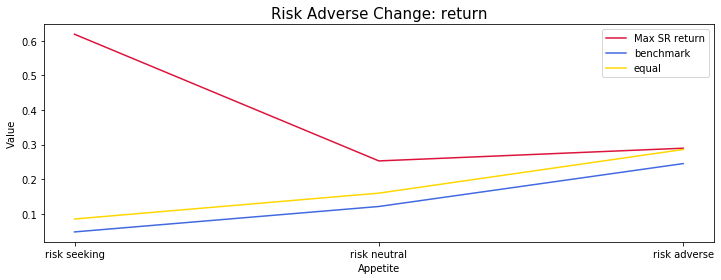

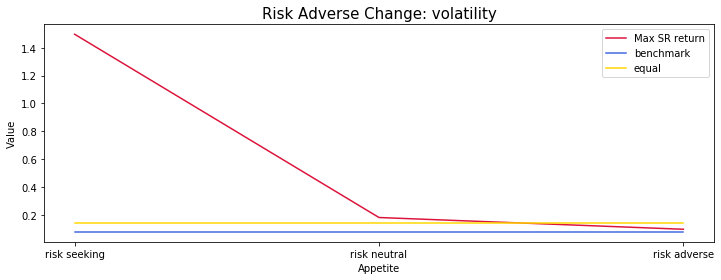

In [187]:
graph_risk_adverse_trend(risk_averse_comp, "return", ["Max SR return", "benchmark", "equal"])
graph_risk_adverse_trend(risk_averse_comp, "volatility", ["Max SR return", "benchmark", "equal"])

# Part III - Backtesting

Assume the backtesting starts from "2022-01-02", using 2 weeks' data to test the posterior return, which adjusted by using the previous two weeks' data, generated weightings. The time window of the views acquisition and the backtesting are the same.
- Assume the **initial capital** is $1,000,000.
- Assume using the robust investment strategy.

In [188]:
INITIAL = 1000000

## Get OOT data

In [189]:
oot_start_dt, oot_end_dt = "2021-12-30", "2022-01-17"

In [190]:
oot_us_data = request_close_data(us_stocks, "us", start_date=oot_start_dt, end_date=oot_end_dt)
oot_uk_data = request_close_data(uk_stocks, "uk", start_date=oot_start_dt, end_date=oot_end_dt)
oot_bond_data = request_close_data(bond_tickers, "bond", start_date=oot_start_dt, end_date=oot_end_dt)
oot_commodity_data = request_close_data(commodity_tickers, "comd", start_date=oot_start_dt, end_date=oot_end_dt)

In [191]:
oot = pd.concat([oot_us_data, oot_uk_data, oot_bond_data, oot_commodity_data], axis=1).fillna(method="ffill")
oot = oot.loc[(oot.index >= "2022-01-03")].T

oot = oot[oot.index.isin(robust_df["asset"])]
display(oot.head())
print(len(oot))

Date,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-10,2022-01-11,2022-01-12,2022-01-13,2022-01-14
us_AZO,2045.109985,2080.250000,2034.030029,2062.489990,2014.770020,2012.660034,2000.979980,2052.879883,2048.399902,2033.479980
us_KMB,142.429993,143.199997,144.059998,143.119995,143.740005,144.589996,143.139999,143.089996,142.889999,143.199997
us_MO,47.970001,49.029999,48.639999,49.209999,49.770000,50.540001,49.480000,49.490002,50.310001,50.810001
us_SPGI,461.100006,459.820007,455.760010,451.959991,446.750000,435.390015,441.019989,447.839996,436.269989,432.359985
us_AIZ,156.270004,157.740005,156.309998,155.830002,158.740005,156.350006,157.470001,157.080002,155.949997,154.889999


82


## P & L

#### Calculate the units of each asset
Denote the initial value as $V$, the price of each asset as $p_i$, the unit of each asset as $u_i$, the weighting of each asset as $w_i$, then there is the following relationship:
$$
\frac{P\times U}{V}=W
$$
where:
- $P=(p_1,p_2,\cdots)^T$
- $U=(u_1,u_2,\cdots)^T$
- $W=(w_1,w_2,\cdots)^T$
<br>
Thus, the units of assets can be calculated by:
$$
U=\frac{W}{P}\cdot V
$$

In [193]:
def compute_asset_units(initial_p: np.array, initial_wealth: int, w: np.array):
    """
    Compute each asset units in the portfolio according to th initial wealth and weighting got.
    :params initial_p: The initial price of each asset.
    :params initial_wealth: The initial wealth of the agent.
    :params w: The weights of the agent's investment strategy.
    :return: The array of the asset units.
    """
    initial_p, w = initial_p.reshape(-1, 1), w.reshape(-1, 1)
    u = w / initial_p * initial_wealth
    return u

#### <font color="sandybrown">Robust covariance</font>

In [194]:
w_bm = np.array(robust_df["weight"]).reshape(-1, 1)
w_mv = np.array(robust_df["plane weight"]).reshape(-1, 1)
w_sr = np.array(robust_df["max SR weight"]).reshape(-1, 1)
w_n = np.array([1 / len(robust_df)] * len(robust_df)).reshape(-1, 1)

In [195]:
initial_price = np.array(oot["2022-01-03"])
u_bm = compute_asset_units(initial_price, INITIAL, w_bm)
u_mv = compute_asset_units(initial_price, INITIAL, w_mv)
u_sr = compute_asset_units(initial_price, INITIAL, w_sr)
u_n = compute_asset_units(initial_price, INITIAL, w_n)

#### Calculate the backtesting window portfolio return

In [196]:
val_bm, val_mv, val_sr, val_n = [], [], [], []
for date in oot.columns:
    close = np.array(oot[date]).reshape(-1, 1)
    day_bm_val, day_n_val = np.dot(close.T, u_bm), np.dot(close.T, u_n)
    day_mv_val, day_sr_val = np.dot(close.T, u_mv), np.dot(close.T, u_sr)
    val_bm.append(round(day_bm_val.flat[0], 2))
    val_n.append(round(day_n_val.flat[0], 2))
    val_mv.append(round(day_mv_val.flat[0], 2))
    val_sr.append(round(day_sr_val.flat[0], 2))

<font color="sandybrown">Adjust the mean variance portfolio wealth because it is not fully invested in the market.</font>
<br>Assume the rest money invested in the risk-free asset.

##### Wealth

In [197]:
rest_wealth = INITIAL - val_mv[0]
display(rest_wealth)

date_arr = oot.columns
date_arr = (date_arr - date_arr[0]).days
display(date_arr)

rf_wealth = (date_arr * r_f / 100 + 1) * rest_wealth
display(rf_wealth)
val_mv += rf_wealth
display(val_mv)

386359.05000000005

Int64Index([0, 1, 2, 3, 4, 7, 8, 9, 10, 11], dtype='int64', name='Date')

Float64Index([386359.05000000005, 386359.55586324073, 386360.06172648136,
              386360.56758972205,  386361.0734529627,  386362.5910426847,
               386363.0969059253,   386363.602769166,  386364.1086324066,
               386364.6144956473],
             dtype='float64', name='Date')

Float64Index([         1000000.0, 1003029.7858632407,  999455.8717264815,
               994910.8475897221,  995718.7334529627,  994155.8210426846,
              1000689.1069059253,  1002540.342769166, 1000408.4786324066,
              1000144.6244956474],
             dtype='float64', name='Date')

##### Return

In [198]:
val_bm, val_mv, val_sr, val_n = np.array(val_bm), np.array(val_mv), np.array(val_sr), np.array(val_n)
retn_bm = np.log(val_bm / val_bm[0]) * 100
retn_n = np.log(val_n / val_n[0]) * 100
retn_mv = np.log(val_mv / val_mv[0]) * 100
retn_sr = np.log(val_sr / val_sr[0]) * 100

##### Portfolio infomation

In [199]:
cols = [
    ("Wealth", "benchmark"), ("Wealth", "1/n"), ("Wealth", "mean variance"), ("Wealth", "max sharp ratio"),
    ("Return (%)", "benchmark"), ("Return (%)", "1/n"), ("Return (%)", "mean variance"), ("Return (%)", "max sharp ratio")
]
portfolio = pd.DataFrame(
    index = oot.columns,
    columns = pd.MultiIndex.from_tuples(cols)
)
portfolio[("Wealth", "benchmark")] = val_bm
portfolio[("Wealth", "1/n")] = val_n
portfolio[("Wealth", "mean variance")] = val_mv
portfolio[("Wealth", "max sharp ratio")] = val_sr
portfolio[("Return (%)", "benchmark")] = retn_bm
portfolio[("Return (%)", "1/n")] = retn_n
portfolio[("Return (%)", "mean variance")] = retn_mv
portfolio[("Return (%)", "max sharp ratio")] = retn_sr

In [200]:
display(portfolio)

Wealth                                                \
                benchmark            1/n  mean variance max sharp ratio   
Date                                                                      
2022-01-03 1000000.000000 1000000.000000 1000000.000000  1000000.000000   
2022-01-04 1003838.790000 1004803.070000 1003029.785863  1004936.880000   
2022-01-05  995144.070000  995352.420000  999455.871726   999111.720000   
2022-01-06  993200.480000  991628.060000  994910.847590   991703.720000   
2022-01-07  992402.600000  990979.750000  995718.733453   993019.620000   
2022-01-10  990059.530000  987531.490000  994155.821043   990470.030000   
2022-01-11  999113.860000  995804.240000 1000689.106906  1001116.610000   
2022-01-12 1003831.890000 1000967.610000 1002540.342769  1004132.810000   
2022-01-13  996748.140000  994335.310000 1000408.478632  1000657.670000   
2022-01-14  994011.310000  989462.770000 1000144.624496  1000226.950000   

           Return (%)                                          
            benchmark       1/n mean variance max sharp ratio  
Date                                                           
2022-01-03   0.000000  0.000000      0.000000        0.000000  
2022-01-04   0.383144  0.479157      0.302521        0.492473  
2022-01-05  -0.486776 -0.465841     -0.054428       -0.088867  
2022-01-06  -0.682274 -0.840718     -0.510215       -0.833089  
2022-01-07  -0.762641 -0.906118     -0.429046       -0.700486  
2022-01-10  -0.999021 -1.254689     -0.586132       -0.957567  
2022-01-11  -0.088653 -0.420459      0.068887        0.111599  
2022-01-12   0.382457  0.096714      0.253712        0.412429  
2022-01-13  -0.325716 -0.568080      0.040840        0.065745  
2022-01-14  -0.600669 -1.059314      0.014461        0.022692

In [212]:
for item in ["benchmark", "1/n", "mean variance", "max sharp ratio"]:
    print("{} volatility: {:.3f}".format(item, np.cov(portfolio[("Return (%)", item)])))

benchmark volatility: 0.227
1/n volatility: 0.304
mean variance volatility: 0.097
max sharp ratio volatility: 0.258


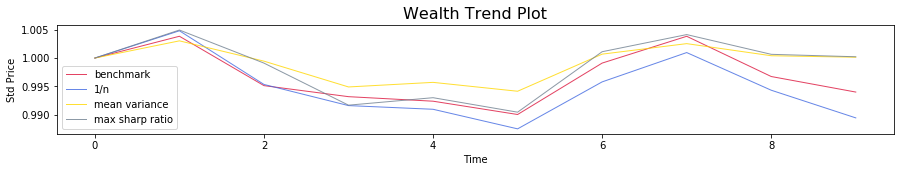

In [215]:
graph_time_series_plot(portfolio["Wealth"], "Wealth", legend=True, fig_size=(15, 2))

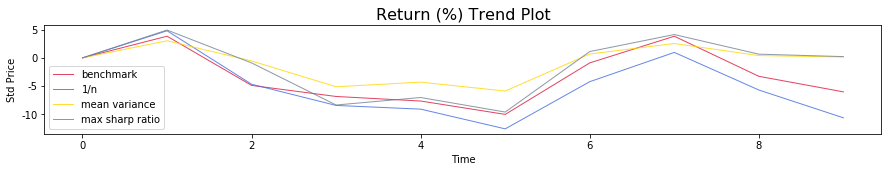

In [216]:
graph_time_series_plot(portfolio["Return (%)"], "Return (%)", legend=True, fig_size=(15, 2))

#### <font color="sandybrown">Naive covariance</font>

In [205]:
w_bm = np.array(naive_df["weight"]).reshape(-1, 1)
w_mv = np.array(naive_df["plane weight"]).reshape(-1, 1)
w_sr = np.array(naive_df["max SR weight"]).reshape(-1, 1)
w_n = np.array([1 / len(naive_df)] * len(naive_df)).reshape(-1, 1)
initial_price = np.array(oot["2022-01-03"])
u_bm = compute_asset_units(initial_price, INITIAL, w_bm)
u_mv = compute_asset_units(initial_price, INITIAL, w_mv)
u_sr = compute_asset_units(initial_price, INITIAL, w_sr)
u_n = compute_asset_units(initial_price, INITIAL, w_n)

val_bm, val_mv, val_sr, val_n = [], [], [], []
for date in oot.columns:
    close = np.array(oot[date]).reshape(-1, 1)
    day_bm_val, day_n_val = np.dot(close.T, u_bm), np.dot(close.T, u_n)
    day_mv_val, day_sr_val = np.dot(close.T, u_mv), np.dot(close.T, u_sr)
    val_bm.append(round(day_bm_val.flat[0], 2))
    val_mv.append(round(day_mv_val.flat[0], 2))
    val_sr.append(round(day_sr_val.flat[0], 2))
    val_n.append(round(day_n_val.flat[0], 2))

rest_wealth = INITIAL - val_mv[0]
display(rest_wealth)

date_arr = oot.columns
date_arr = (date_arr - date_arr[0]).days
display(date_arr)

rf_wealth = (date_arr * r_f / 100 + 1) * rest_wealth
display(rf_wealth)
val_mv += rf_wealth
display(val_mv)

val_bm, val_mv, val_sr, val_n = np.array(val_bm), np.array(val_mv), np.array(val_sr), np.array(val_n)
retn_bm = np.log(val_bm / val_bm[0]) * 100
retn_n = np.log(val_n / val_n[0]) * 100
retn_mv = np.log(val_mv / val_mv[0]) * 100
retn_sr = np.log(val_sr / val_sr[0]) * 100

373588.22

Int64Index([0, 1, 2, 3, 4, 7, 8, 9, 10, 11], dtype='int64', name='Date')

Float64Index([         373588.22,  373588.7091422826,  373589.1982845653,
              373589.68742684793, 373590.17656913056,  373591.6439959786,
               373592.1331382612, 373592.62228054384, 373593.11142282654,
              373593.60056510917],
             dtype='float64', name='Date')

Float64Index([         1000000.0, 1003148.5791422826,  999602.4182845652,
               994825.2074268479,  995654.9765691306,  994066.4839959785,
              1000726.6931382613, 1002588.4622805438, 1000512.4214228266,
              1000244.0605651091],
             dtype='float64', name='Date')

In [206]:
cols = [
    ("Wealth", "benchmark"), ("Wealth", "1/n"), ("Wealth", "mean variance"), ("Wealth", "max sharp ratio"),
    ("Return (%)", "benchmark"), ("Return (%)", "1/n"), 
    ("Return (%)", "mean variance"), ("Return (%)", "max sharp ratio")
]
portfolio_naive = pd.DataFrame(
    index = oot.columns,
    columns = pd.MultiIndex.from_tuples(cols)
)
portfolio_naive[("Wealth", "benchmark")] = val_bm
portfolio_naive[("Wealth", "1/n")] = val_n
portfolio_naive[("Wealth", "mean variance")] = val_mv
portfolio_naive[("Wealth", "max sharp ratio")] = val_sr
portfolio_naive[("Return (%)", "benchmark")] = retn_bm
portfolio_naive[("Return (%)", "1/n")] = retn_n
portfolio_naive[("Return (%)", "mean variance")] = retn_mv
portfolio_naive[("Return (%)", "max sharp ratio")] = retn_sr

In [207]:
display(portfolio_naive)

Wealth                                                \
                benchmark            1/n  mean variance max sharp ratio   
Date                                                                      
2022-01-03 1000000.000000 1000000.000000 1000000.000000  1000000.000000   
2022-01-04 1003838.790000 1004803.070000 1003148.579142  1005025.790000   
2022-01-05  995144.070000  995352.420000  999602.418285   999363.880000   
2022-01-06  993200.480000  991628.060000  994825.207427   991736.440000   
2022-01-07  992402.600000  990979.750000  995654.976569   993060.410000   
2022-01-10  990059.530000  987531.490000  994066.483996   990522.080000   
2022-01-11  999113.860000  995804.240000 1000726.693138  1001154.010000   
2022-01-12 1003831.890000 1000967.610000 1002588.462281  1004125.430000   
2022-01-13  996748.140000  994335.310000 1000512.421423  1000810.370000   
2022-01-14  994011.310000  989462.770000 1000244.060565  1000381.240000   

           Return (%)                                          
            benchmark       1/n mean variance max sharp ratio  
Date                                                           
2022-01-03   0.000000  0.000000      0.000000        0.000000  
2022-01-04   0.383144  0.479157      0.314363        0.501320  
2022-01-05  -0.486776 -0.465841     -0.039766       -0.063632  
2022-01-06  -0.682274 -0.840718     -0.518823       -0.829789  
2022-01-07  -0.762641 -0.906118     -0.435449       -0.696378  
2022-01-10  -0.999021 -1.254689     -0.595119       -0.952312  
2022-01-11  -0.088653 -0.420459      0.072643        0.115334  
2022-01-12   0.382457  0.096714      0.258512        0.411694  
2022-01-13  -0.325716 -0.568080      0.051229        0.081004  
2022-01-14  -0.600669 -1.059314      0.024403        0.038117

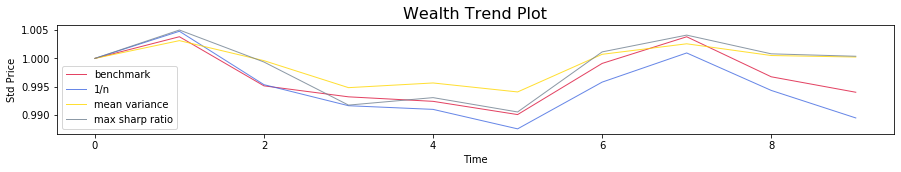

In [219]:
graph_time_series_plot(portfolio_naive["Wealth"], "Wealth", legend=True, fig_size=(15, 2))

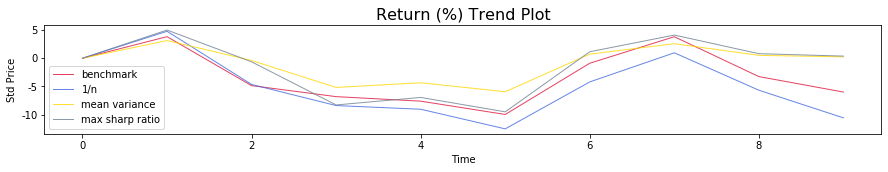

In [220]:
graph_time_series_plot(portfolio_naive["Return (%)"], "Return (%)", legend=True, fig_size=(15, 2))

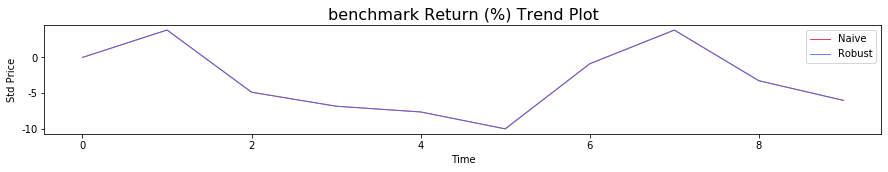

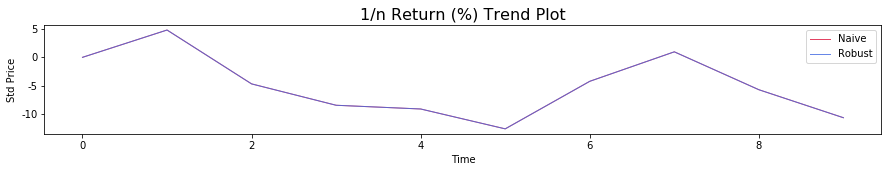

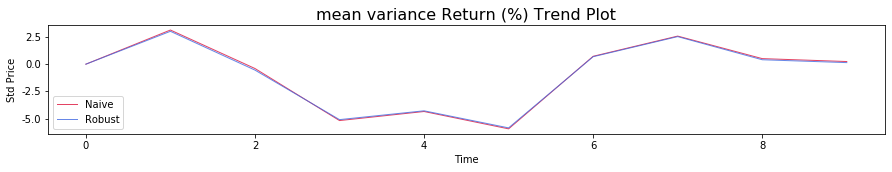

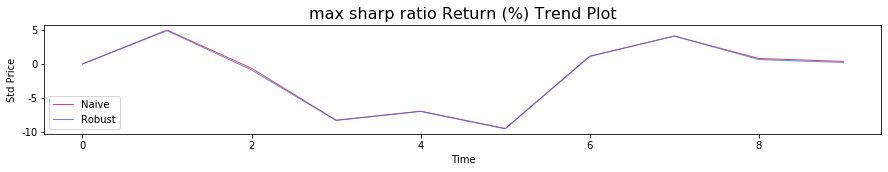

In [224]:
for i, j in portfolio.columns[:4]:
    df = pd.DataFrame({
        "Naive": portfolio_naive[("Return (%)", j)],
        "Robust": portfolio[("Return (%)", j)]
    })
    graph_time_series_plot(df, "{} Return (%)".format(j), legend=True, fig_size=(15, 2))

### Betas

In [302]:
robust_df = pd.merge(robust_df, beta_df[["asset", "coefficient"]], on="asset", how="left")
display(robust_df.head())

,asset,return,weight,posterior return,plane weight,max SR weight,coefficient
0,us_AZO,0.163782,0.009781,0.339864,0.004891,0.007970,1.271112
1,us_KMB,0.096389,0.007540,0.127690,0.003770,0.006144,0.687725
2,us_MO,0.092851,0.007540,0.220949,0.003770,0.006144,1.119993
3,us_SPGI,0.170983,0.014549,0.258673,0.007275,0.011856,1.797629
4,us_AIZ,0.121753,0.014549,0.271397,0.007275,0.011856,1.651980


In [244]:
def get_index_long_short_change(df: pd.DataFrame, col: str):
    """
    Get the index of long short weighting change.
    """
    sign = df[[col]].sort_values(col).reset_index(drop=True)
    sign["sign"] = sign[col].apply(lambda x: np.sign(x))
    sign["signal"] = (sign["sign"].shift(1) - sign["sign"]).fillna(0)
    return sign[sign["signal"] != 0].index[0]

##### Using equilibrium return

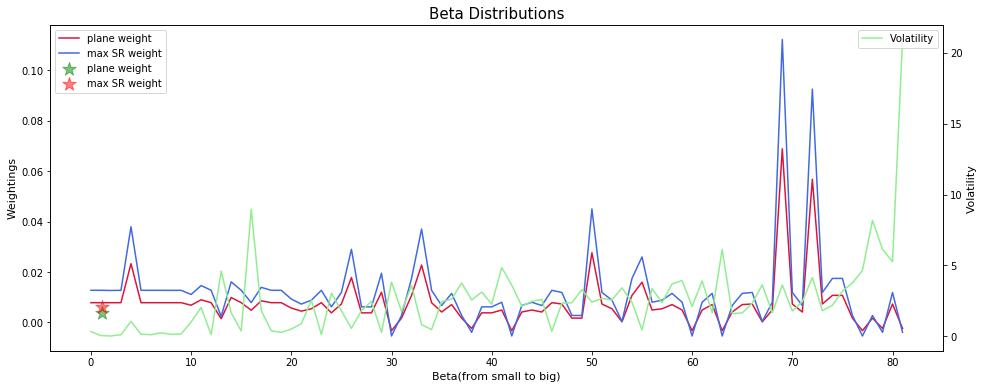

In [319]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots()
ax_ = ax.twinx()
x, colors = np.arange(len(df)), ["green", "red"]
for e, item in enumerate(["plane weight", "max SR weight"]):
    df = robust_df[[item, "coefficient"]].sort_values("coefficient")
    ind = get_index_long_short_change(df, "coefficient")
    x_scatter, y_scatter = df.loc[ind, ["coefficient", item]]
    cov_df = pd.DataFrame({
        "cov": np.diag(new_cov),
        "coefficient": np.array(robust_df["coefficient"])
    }).sort_values("coefficient")

    ax.plot(x, np.array(df[item]), label=item, color=color_list[e])
    ax.scatter(x_scatter, y_scatter, c=colors[e], marker="*", label=item, s=200, alpha=0.5)
ax_.plot(x, np.array(cov_df["cov"]), label="Volatility", color=color_list[-1])
plt.title("Beta Distributions", fontsize=15)
ax.set_xlabel("Beta(from small to big)", fontsize=11)
ax.set_ylabel("Weightings", fontsize=11)
ax_.set_ylabel("Volatility", fontsize=11)
ax.legend(loc="upper left")
ax_.legend(loc="upper right")
plt.show()

##### Using naive return

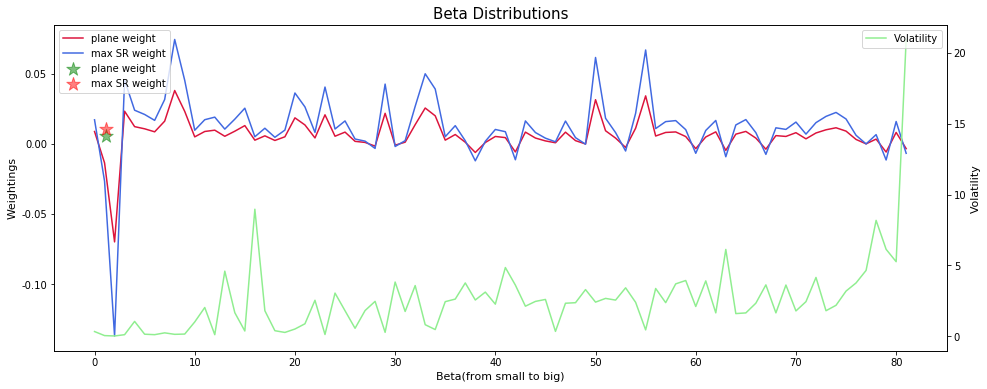

In [318]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots()
ax_ = ax.twinx()
x, colors, wt = np.arange(len(df)), ["green", "red"], [plane_nw.flatten(), max_sr_nw.flatten()]
for e, item in enumerate(["plane weight", "max SR weight"]):
    df = pd.DataFrame({
        item: wt[e],
        "coefficient": robust_df["coefficient"]
    }).sort_values("coefficient")
    ind = get_index_long_short_change(df, "coefficient")
    x_scatter, y_scatter = df.loc[ind, ["coefficient", item]]
    cov_df = pd.DataFrame({
        "cov": np.diag(new_cov),
        "coefficient": np.array(robust_df["coefficient"])
    }).sort_values("coefficient")

    ax.plot(x, np.array(df[item]), label=item, color=color_list[e])
    ax.scatter(x_scatter, y_scatter, c=colors[e], marker="*", label=item, s=200, alpha=0.5)
ax_.plot(x, np.array(cov_df["cov"]), label="Volatility", color=color_list[-1])
plt.title("Beta Distributions", fontsize=15)
ax.set_xlabel("Beta(from small to big)", fontsize=11)
ax.set_ylabel("Weightings", fontsize=11)
ax_.set_ylabel("Volatility", fontsize=11)
ax.legend(loc="upper left")
ax_.legend(loc="upper right")
plt.show()

In [325]:
df = pd.DataFrame({
    "max SR": max_sr_nw.flatten(),
    "coefficient": robust_df["coefficient"],
    "volatility": np.array(cov_df["cov"]),
    "asset": robust_df["asset"]
})
display(df[df["max SR"] < 0])

,max SR,coefficient,volatility,asset
9,-0.000293,1.314798,0.154873,us_IRM
13,-0.007562,1.682507,4.596007,us_NRG
14,-0.005152,1.357189,1.663641,us_FE
15,-0.000107,2.531673,0.372084,us_LYB
16,-0.006789,1.424347,8.967623,us_SHW
22,-0.006803,3.819196,2.540165,us_APA
23,-0.011555,2.963571,0.125528,us_MPC
34,-0.001954,0.705884,0.473909,uk_POLY.L
35,-0.009254,1.625494,2.442786,uk_EVR.L
40,-0.003319,0.688141,2.267017,uk_BNZL.L


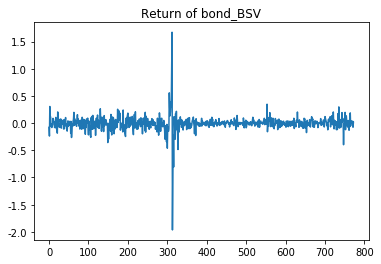

In [333]:
plt.plot(np.arange(len(data)), np.array(data["bond_BSV"]))
plt.title("Return of bond_BSV")
plt.show()

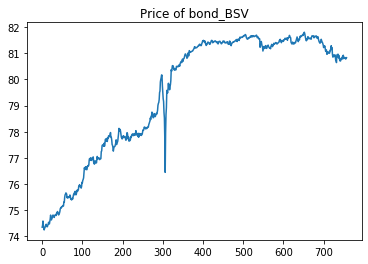

In [334]:
tmp = yf.Ticker("BSV").history(start=start_dt, end=end_dt)
plt.plot(np.arange(len(tmp)), np.array(tmp["Close"]))
plt.title("Price of bond_BSV")
plt.show()